# The Future is Now: Patterns in Global Temperature Trends Across the World

While we all know that global temperatures are on the rise, mass media tends to lack nuance on the topic with its goals of compressing information into brief soundbytes.

For example, it's often not mentioned that the global temperature rise is based on *average* global temperatures, rather than day-to-day, which often leads people to conflate climate and weather. It is also worth highlighting that averages can be skewed by outliers - i.e., unusually hot or cold temperatures on just a few days out of a month can make the average temperature for that month higher or lower by several degrees.

Another feature of climate change not often highlighted is that different parts of the world are warming at different rates,  i.e. some parts of the world are more at risk for the various consequences of climate change than others, particularly in the short term (decades). 

The goal of this analysis is to find which parts of the world have warmed the most. What geographic trends will we find? What regions of the world are most at risk? With data mining techniques, we can better understand which parts of the world will be most at risk, and help provide a more nuanced understanding of climate change.

The following analysis is based on this dataset: [Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) uses the [CC BY-NC-SA 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

## Virtual Environment Setup

Recommended if running locally; not needed if running on Colab or similar.

Add a code cell that runs the following command:
`!py -3 -m venv .venv`

Then in the top right in VS Code click the Python version and set it to the `.venv` interpreter found in this folder.

## Install Dependencies

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels

Note: you may need to restart the kernel to use updated packages.


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pycountry_convert as pc
from kgcPy import lookupCZ
from scipy.stats import linregress
import random

In [2]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)

## Data preprocessing & Exploratory Data Analysis (EDA)

For our first step, I need to examine the data, and determine if there are any data missing; if there are, I should investigate patterns in the missing data.

In [3]:
with open('GlobalLandTemperaturesByCity.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')


<Axes: >

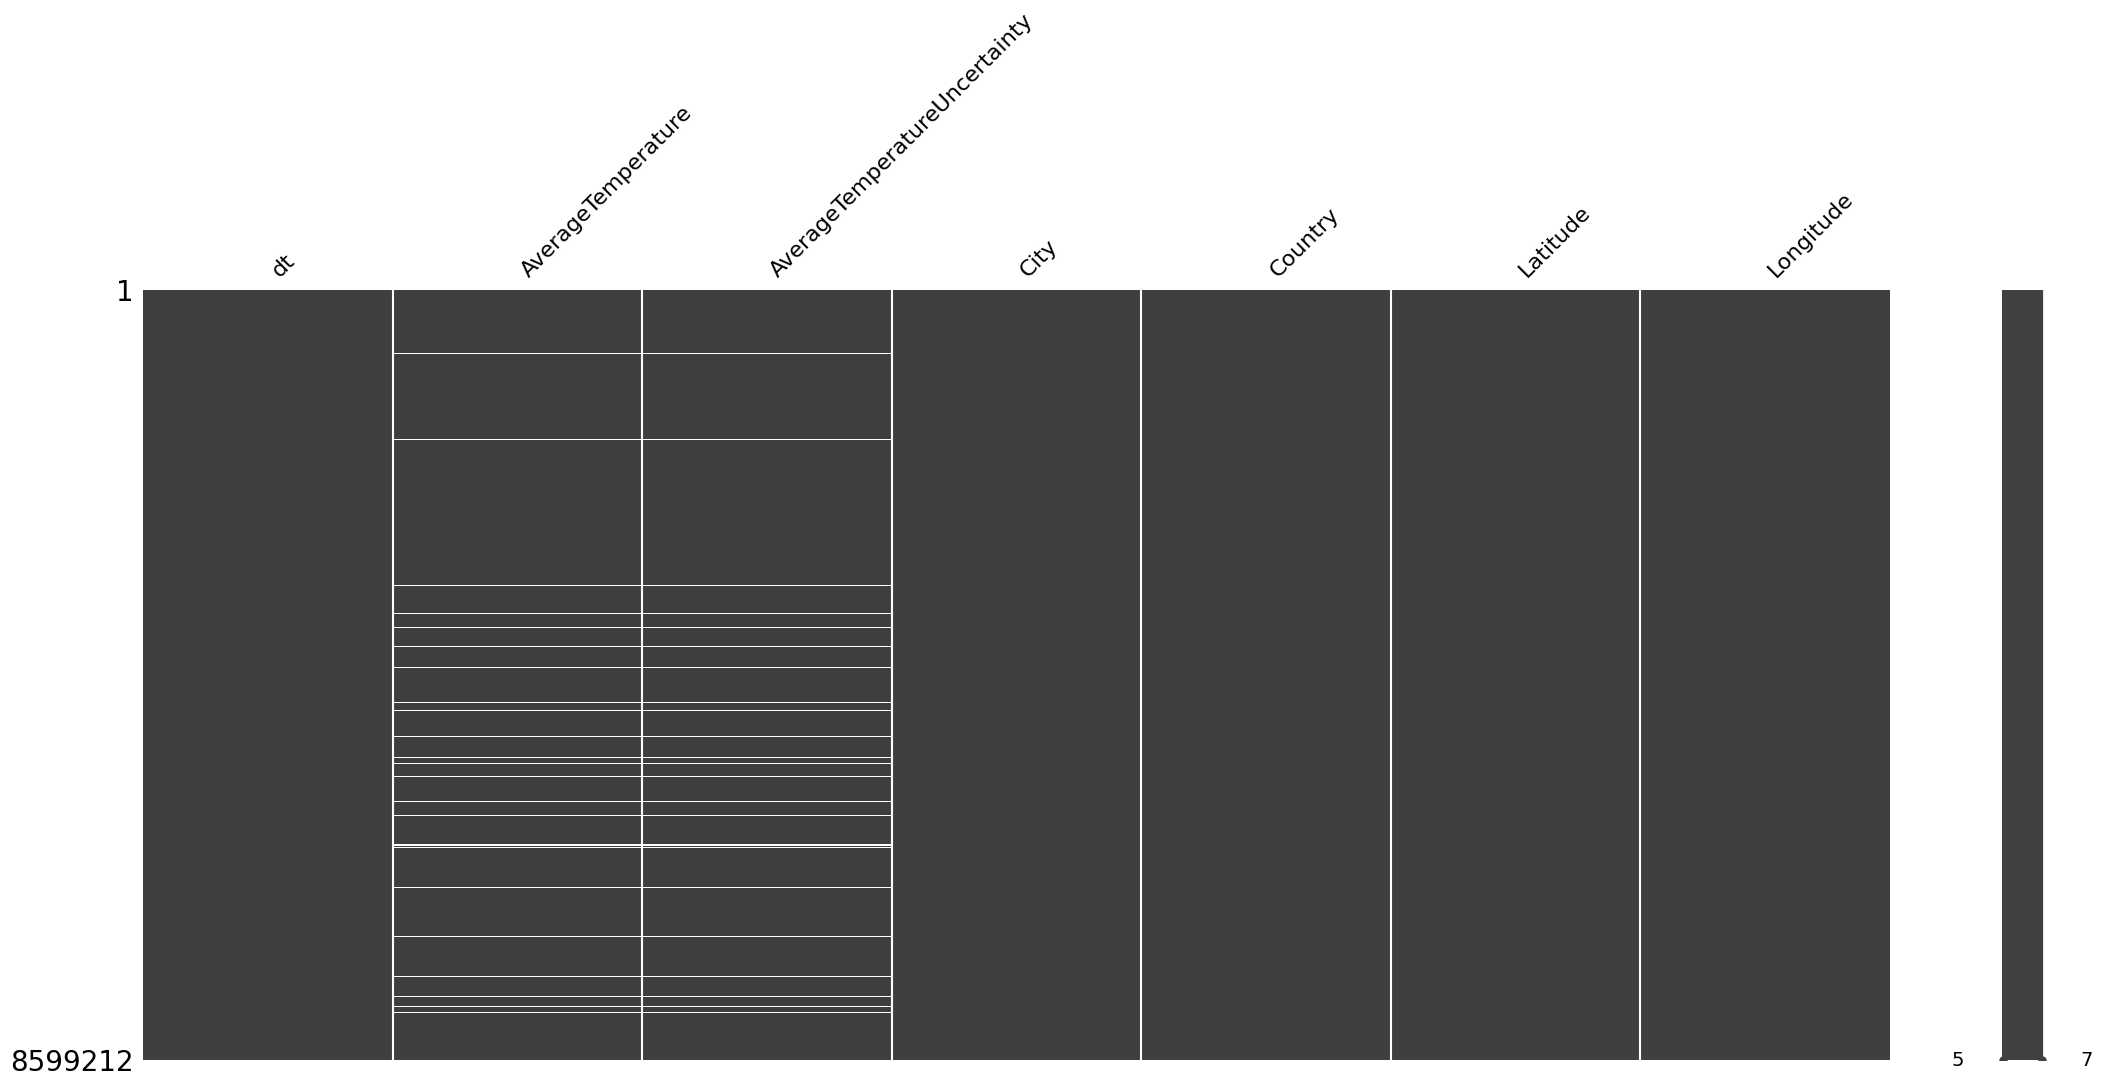

In [4]:
# Find missing values (if any) and where they are
msno.matrix(df)

Quick look at how the data is organized

In [5]:
unique_cities_count = df['City'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

unique_countries_count = df['Country'].nunique()
print(f'Number of unique countries: {unique_countries_count}')

print(df)

df.describe()

Number of unique cities: 3448
Number of unique countries: 159
                 dt  AverageTemperature  AverageTemperatureUncertainty  \
0        1743-11-01               6.068                          1.737   
1        1743-12-01                 NaN                            NaN   
2        1744-01-01                 NaN                            NaN   
3        1744-02-01                 NaN                            NaN   
4        1744-03-01                 NaN                            NaN   
...             ...                 ...                            ...   
8599207  2013-05-01              11.464                          0.236   
8599208  2013-06-01              15.043                          0.261   
8599209  2013-07-01              18.775                          0.193   
8599210  2013-08-01              18.025                          0.298   
8599211  2013-09-01                 NaN                            NaN   

           City      Country Latitude Longitude  

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


### Missing Data & Reliability

From the output above we can see that there are a lot of missing data points, but all of them are in the AverageTemperature column and its dependent column, AverageTemperatureUncertainty.

#### Adjust Years to only include data from 1880 and beyond

For the most robust interpretations, we will only include data from the year 1880 and beyond.

**Why start at the Year 1880?**

- This is the starting year used most consistently by datasets by the National Oceanic and Atmospheric Administration (NOAA) and National Aueronautics and Space Administration (NASA)
- Available temperature data started covering more of the planet around this time so analyses and interpretations are more reliable
- Measurement uncertainty decreases to an acceptable level around this time

In [6]:
# Convert 'dt' to datetime and extract the year
df['Year'] = pd.to_datetime(df['dt']).dt.year
df = df[df['Year'] >= 1880]

# Group by city/year to find where most of the values are missing
df_missing_city_year = df[df['AverageTemperature'].isnull()].groupby(['City', 'Year']).size().reset_index(name='MissingCount')
print('Missing Average Temperature entries by year and city:')
print(df_missing_city_year)

# Look at just city to see geographical trends
df_missing_city = df[df['AverageTemperature'].isnull()].groupby('City').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by city:')
print(df_missing_city)

# Look at just year to see temporal trends
df_missing_years_city = df[df['AverageTemperature'].isnull()].groupby('Year').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by year (across all cities):')
print(df_missing_years_city)

# Get rid of rows where AverageTemperatureUncertainty is > 5 degrees Celsius and see how that changes things
df = df[df['AverageTemperatureUncertainty'] <= 5]

print('---------------------------------------------------')
print('Results after removing rows where AverageTemperatureUncertainty > 5')

# Repeat what we did above
df_missing_years_city = df[df['AverageTemperature'].isnull()].groupby('Year').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by year (across all cities):')
print(df_missing_years_city)

Missing Average Temperature entries by year and city:
          City  Year  MissingCount
0     A Coruña  2013             1
1       Aachen  2013             1
2      Aalborg  2013             1
3          Aba  2013             1
4       Abadan  2013             1
...        ...   ...           ...
4182     Århus  2013             1
4183     Çorlu  2013             1
4184     Çorum  2013             1
4185   Öskemen  2013             1
4186    Ürümqi  2013             1

[4187 rows x 3 columns]

Missing Average Temperature entries by city:
             City  MissingCount
1945       Olinda           141
1245  João Pessoa           141
2029   Parnamirim           141
2365   Santa Rita           141
2047     Paulista           141
...           ...           ...
1067   Hulan Ergi             1
1068        Humen             1
1069       Huzhou             1
1072     Hòa Bình             1
3044       Ürümqi             1

[3045 rows x 2 columns]

Missing Average Temperature entries by year (

### Handling Years With Missing Data

Inevitably, some years will have a month or perhaps a whole year's Average Temperature data missing.

Including years with some months missing could easily misrepresent the average, particularly for countries far from the equator, where there can be a large seasonal variation in temperature. We want to minimize the influence of incomplete or missing data.

To keep the reliability and integrity of this data analysis, I will be using the following approach:

1. Exclude all years for a city where at least 1 month is missing a value for AverageTemperature, put that in a new dataframe.
2. Average the temperature for each year on the rest of the data, so we can compare temperature trends over time across countries.

* Note: this approach results in no additional years being excluded since we decided to start from year 1880 and exclude years where `AverageTemperatureUncertainty` was >5.

In [7]:
# Find any cities that have missing temperature data for a year
missing_AverageTemperature = df.groupby(['City', 'Year'])['AverageTemperature'].apply(lambda x: x.isnull().any()).reset_index(name='HasMissing')

# Create a new df that only includes years without missing data
df_no_missing = missing_AverageTemperature[~missing_AverageTemperature['HasMissing']]

# Filter to only include rows with complete years - now we've only got years with 0 missing Average Temperature entries
df_no_missing = pd.merge(df, df_no_missing[['City', 'Year']], on=['City', 'Year'], how='inner')

# Calculate the average temperature for each city by year
df_AverageTemperature_City_Year = df_no_missing.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

df_updated = df_AverageTemperature_City_Year

print(df_updated)

df_updated.describe()

            City  Year  AverageTemperature
0       A Coruña  1880           12.837750
1       A Coruña  1881           13.405000
2       A Coruña  1882           12.776250
3       A Coruña  1883           12.260833
4       A Coruña  1884           12.693250
...          ...   ...                 ...
461607    Ürümqi  2009            7.287417
461608    Ürümqi  2010            6.650083
461609    Ürümqi  2011            6.806083
461610    Ürümqi  2012            6.600167
461611    Ürümqi  2013            9.472000

[461612 rows x 3 columns]


,Year,AverageTemperature
count,461612.000000,461612.000000
mean,1946.555872,17.751024
std,38.654517,7.689601
min,1880.000000,-14.812000
25%,1913.000000,11.487646
50%,1947.000000,18.502333
75%,1980.000000,25.236854
max,2013.000000,31.082625


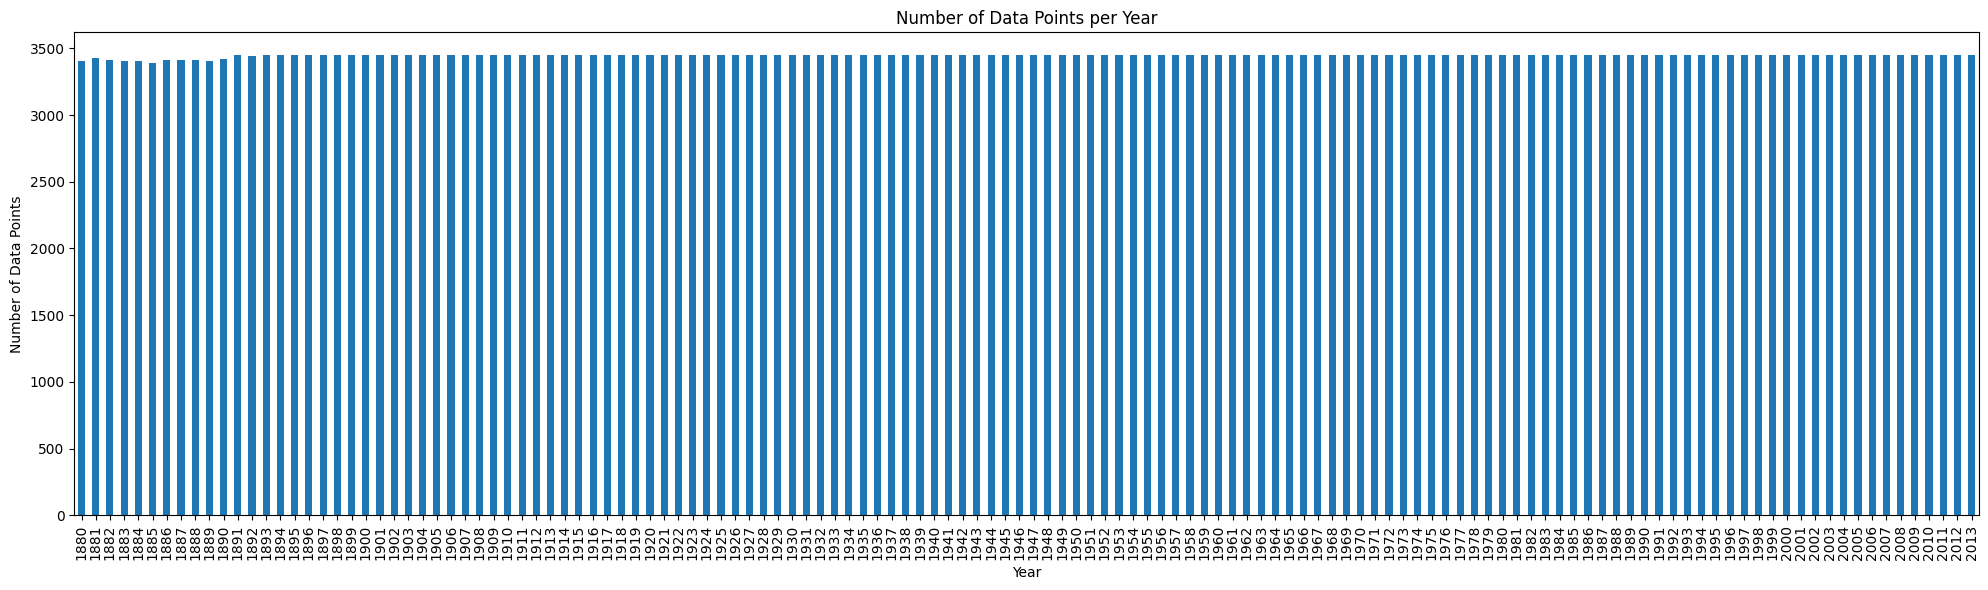

count     134.000000
mean     3444.865672
std        10.719802
min      3388.000000
25%      3448.000000
50%      3448.000000
75%      3448.000000
max      3448.000000
dtype: float64

In [8]:
data_points_per_year = df_updated.groupby('Year').size()

plt.figure(figsize=(20, 6))
data_points_per_year.plot(kind='bar')
plt.title('Number of Data Points per Year')
plt.xlabel('Year')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

data_points_per_year.describe()

<Axes: >

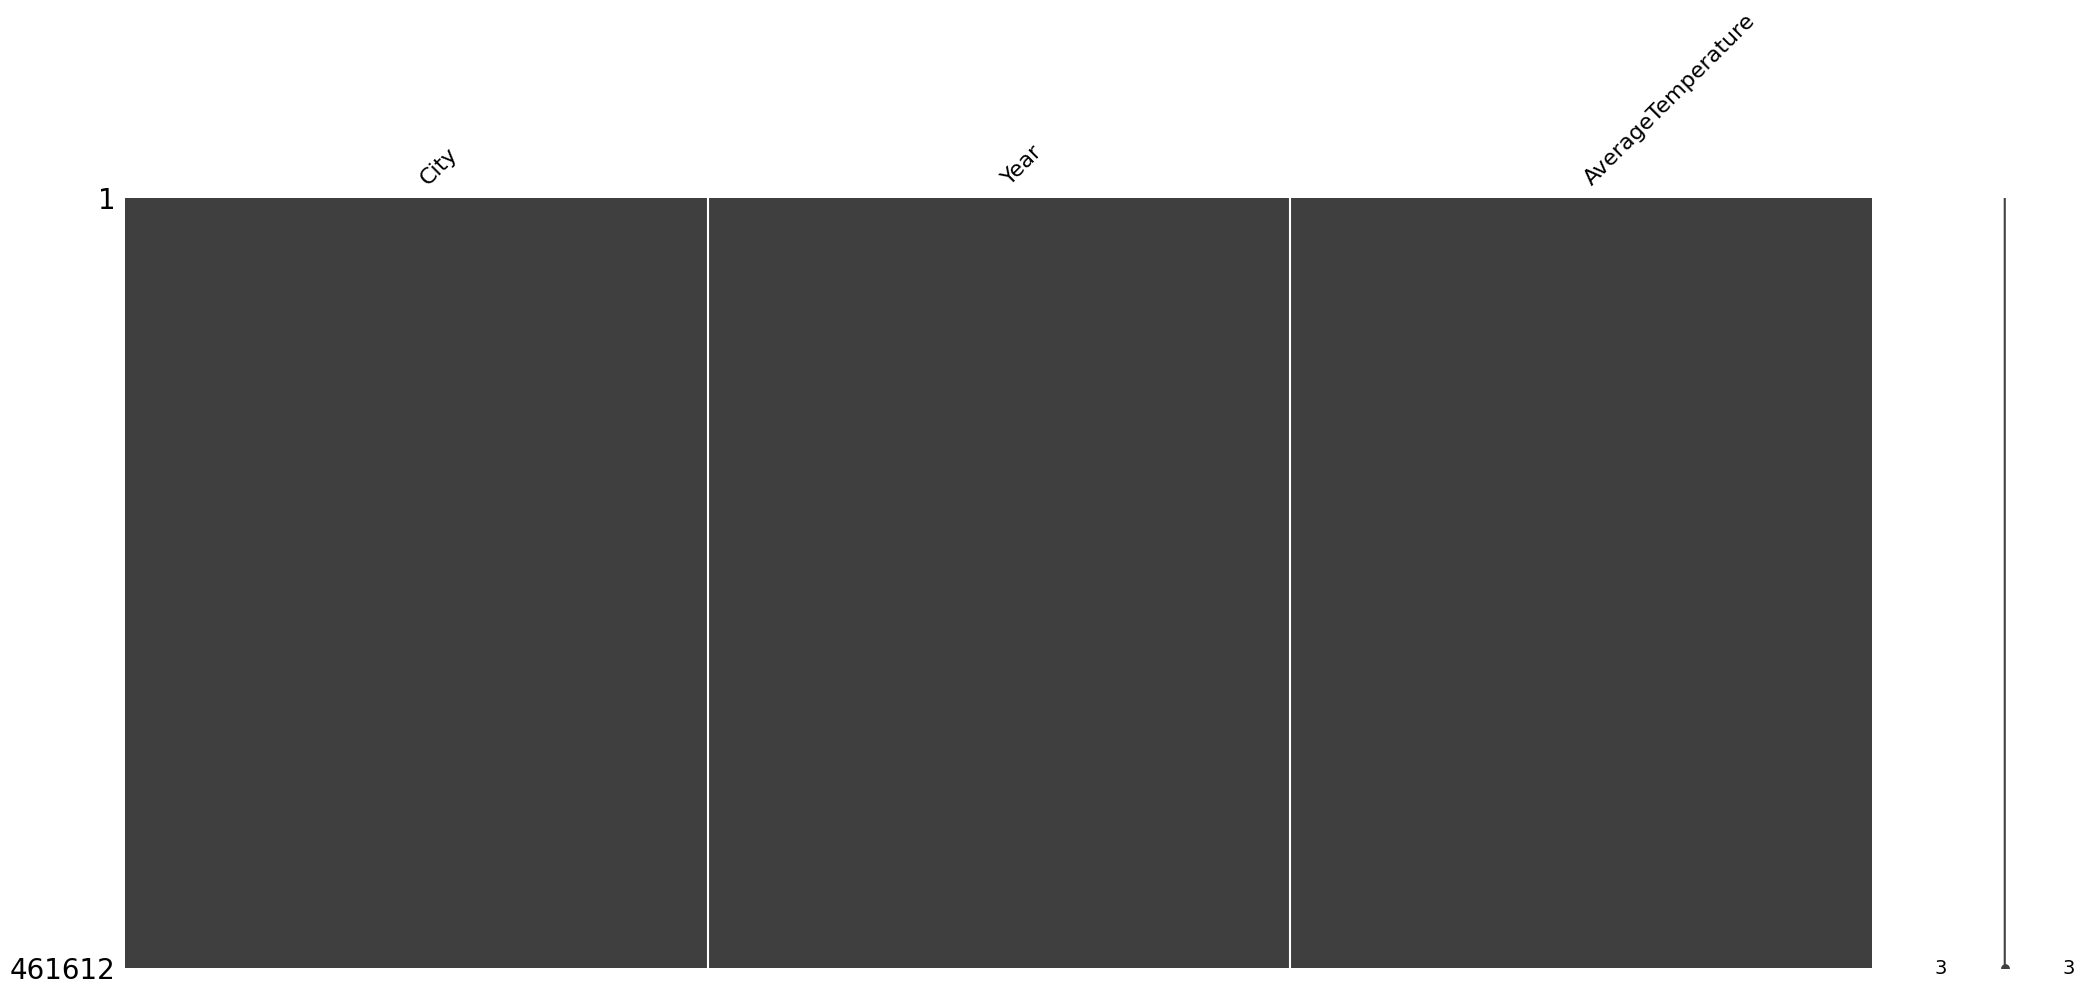

In [9]:
# Confirm there is no missing data
msno.matrix(df_updated)

In [10]:
unique_cities_count = df_updated['City'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

# Group by Year and count the number of data points (Cities) for each year
num_data_points = df_updated.groupby('Year').size()

print(f'Minimum data points in a year: {num_data_points.min()}')
print(f'Maximum data points in a year: {num_data_points.max()}')

missing_values = df.isnull().any()

print("Missing values per column:")
print(missing_values)

Number of unique cities: 3448
Minimum data points in a year: 3388
Maximum data points in a year: 3448
Missing values per column:
dt                               False
AverageTemperature               False
AverageTemperatureUncertainty    False
City                             False
Country                          False
Latitude                         False
Longitude                        False
Year                             False
dtype: bool


### View of Average Temperature Over Time for 5 Random Countries

To verify that my approach is giving the correct results, I have decided to graph 5 random countries' average temperature over time.
Your results will be different every time you run the following cell.

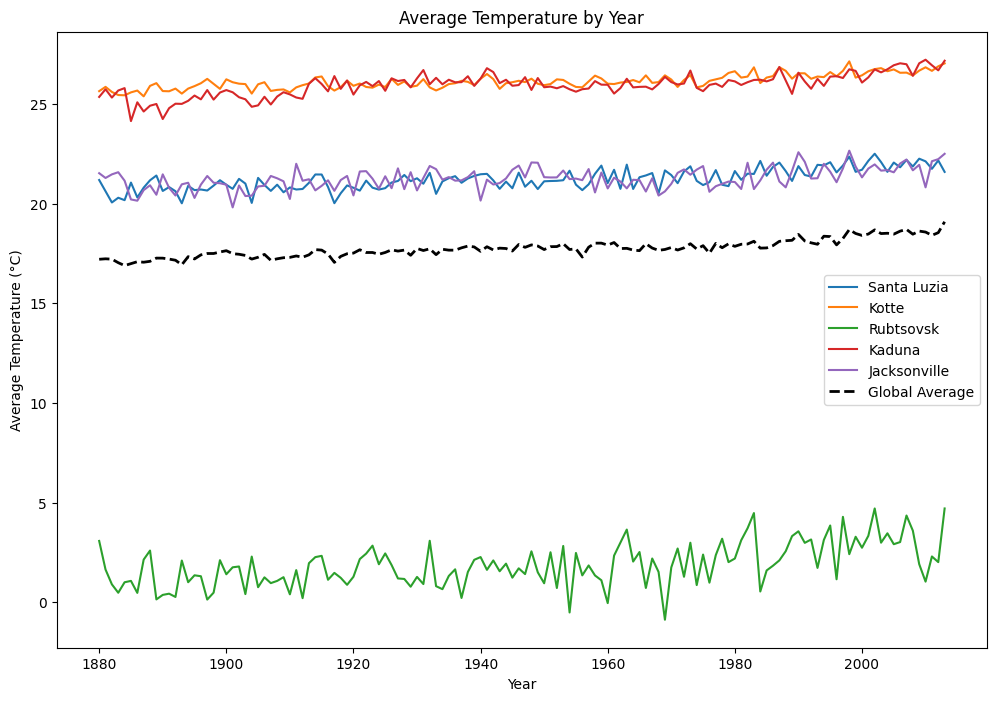

In [11]:
# Get list of unique cities so we can graph by city
unique_cities = df_updated['City'].unique()

# Pick 5 random cities
selected_cities = np.random.choice(unique_cities, 5, replace=False)

plt.figure(figsize=(12, 8))

# Graph AverageTemperature vs. Year for the 5 random cities
for city in selected_cities:
    city_data = df_updated[df_updated['City'] == city]
    plt.plot(city_data['Year'], city_data['AverageTemperature'], label=city)

# Include global for comparison
df_global_average = df_updated.groupby('Year')['AverageTemperature'].mean().reset_index(name='GlobalAverageTemperature')

plt.plot(df_global_average['Year'], df_global_average['GlobalAverageTemperature'], label='Global Average', color='black', linewidth=2, linestyle='--')

plt.title('Average Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

### Correlation Between Latitude and Average Temperature

Latitude is a value measured in degrees with range [-90, 90] that represents physical distance from the equator (0). Cities north of the equator have their latitude suffixed by N (positive), and those south of the equator have it suffixed by S (negative).

For this analysis it makes the most sense to look at absolute latitude to determine if there is a correlation between it and average temperature, since the output should be a line (if there is a correlation). However I will also be examining raw latitude as well, to see if there are any trends within just the Northern or Southern Hemisphere. We expect this curve to be a slightly skewed inverted-U shape since there is less landmass in the southern hemisphere.

It is expected that countries near the equator should have warmer average temperatures than those far from the equator.

In [12]:
additional_details = df_no_missing.groupby(['City', 'Year']).agg({
    'Country': 'first',
    'Latitude': 'first', 
    'Longitude': 'first'
}).reset_index()

df_updated = pd.merge(
    df_updated,
    additional_details,
    on=['City', 'Year'],
    how='left'
)

print(df_updated)

df_updated.describe()

            City  Year  AverageTemperature Country Latitude Longitude
0       A Coruña  1880           12.837750   Spain   42.59N     8.73W
1       A Coruña  1881           13.405000   Spain   42.59N     8.73W
2       A Coruña  1882           12.776250   Spain   42.59N     8.73W
3       A Coruña  1883           12.260833   Spain   42.59N     8.73W
4       A Coruña  1884           12.693250   Spain   42.59N     8.73W
...          ...   ...                 ...     ...      ...       ...
461607    Ürümqi  2009            7.287417   China   44.20N    87.20E
461608    Ürümqi  2010            6.650083   China   44.20N    87.20E
461609    Ürümqi  2011            6.806083   China   44.20N    87.20E
461610    Ürümqi  2012            6.600167   China   44.20N    87.20E
461611    Ürümqi  2013            9.472000   China   44.20N    87.20E

[461612 rows x 6 columns]


,Year,AverageTemperature
count,461612.000000,461612.000000
mean,1946.555872,17.751024
std,38.654517,7.689601
min,1880.000000,-14.812000
25%,1913.000000,11.487646
50%,1947.000000,18.502333
75%,1980.000000,25.236854
max,2013.000000,31.082625


### Enhancing the Dataset

Through some manual inspection I have noticed that the Latitude and Longitude values present in this dataset are only approximate. Since we later want to enhance this dataset with Köppen climate classifications it is important that these are more accurate; for instance, coastal cities appear to be in the ocean.

Externally I used geocode to get more precise city Latitude and Longitude values, then inspected for which cities Latitude and Longitude were different from the originals by at least 4 degrees. I manually searched and re-verified these values; for a number of the city names there is ambiguity, e.g. `Concord, United States`. Most of the cities where the values were significantly off were in India or China; at least in English, the same name can refer to a large number of cities or villages, so manual confirmation was done to make sure that the right location was being selected.

In [13]:
df_coords = pd.read_csv('city_country_with_coordinates.csv',  encoding='utf-8')

# strip "-" for S and W
def format_lat(lat):
    lat_val = float(lat)
    direction = 'N' if lat_val >= 0 else 'S'
    lat_str = str(abs(lat_val))  # Convert to string after removing sign
    return f"{lat_str}{direction}"

def format_lon(lon):
    lon_val = float(lon)
    direction = 'E' if lon_val >= 0 else 'W'
    lon_str = str(abs(lon_val))  # Convert to string after removing sign
    return f"{lon_str}{direction}"

df_coords['Latitude'] = df_coords['Latitude'].apply(format_lat)
df_coords['Longitude'] = df_coords['Longitude'].apply(format_lon)

lat_mapping = df_coords.set_index(['City', 'Country'])['Latitude'].to_dict()
lon_mapping = df_coords.set_index(['City', 'Country'])['Longitude'].to_dict()

df_updated['City_Country'] = df_updated['City'] + '_' + df_updated['Country']
df_updated['Latitude'] = df_updated['City_Country'].map(lambda x: lat_mapping.get(tuple(x.split('_')), None))
df_updated['Longitude'] = df_updated['City_Country'].map(lambda x: lon_mapping.get(tuple(x.split('_')), None))

df_updated.drop('City_Country', axis=1, inplace=True)

df_updated.head()

,City,Year,AverageTemperature,Country,Latitude,Longitude
0,A Coruña,1880,12.837750,Spain,43.3709703N,8.3959425W
1,A Coruña,1881,13.405000,Spain,43.3709703N,8.3959425W
2,A Coruña,1882,12.776250,Spain,43.3709703N,8.3959425W
3,A Coruña,1883,12.260833,Spain,43.3709703N,8.3959425W
4,A Coruña,1884,12.693250,Spain,43.3709703N,8.3959425W


In [14]:
# Add additional latitude/longitude columns for data visualization/processing
df_updated['NumericLatitude'] = df_updated['Latitude'].apply(lambda x: float(x[:-1]) if 'N' in x else -float(x[:-1]))
df_updated['NumericLongitude'] = df_updated['Longitude'].apply(lambda x: float(x[:-1]) if 'E' in x else -float(x[:-1]))
df_updated['AbsLatitude'] = df_updated['NumericLatitude'].abs()
df_updated['AbsLongitude'] = df_updated['NumericLongitude'].abs()

df_updated = df_updated.dropna(subset=['AverageTemperature'])

In [15]:
average_temp_by_latitude = df_updated.groupby('AbsLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_latitude = df_updated.groupby('NumericLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_longitude = df_updated.groupby('AbsLongitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_longitude = df_updated.groupby('NumericLongitude')['AverageTemperature'].mean().reset_index()

# Correlation Analysis
correlation_abs_lat = average_temp_by_latitude['AbsLatitude'].corr(average_temp_by_latitude['AverageTemperature'])
correlation_raw_lat = average_temp_by_raw_latitude['NumericLatitude'].corr(average_temp_by_raw_latitude['AverageTemperature'])
correlation_abs_long = average_temp_by_longitude['AbsLongitude'].corr(average_temp_by_longitude['AverageTemperature'])
correlation_raw_long = average_temp_by_raw_longitude['NumericLongitude'].corr(average_temp_by_raw_longitude['AverageTemperature'])

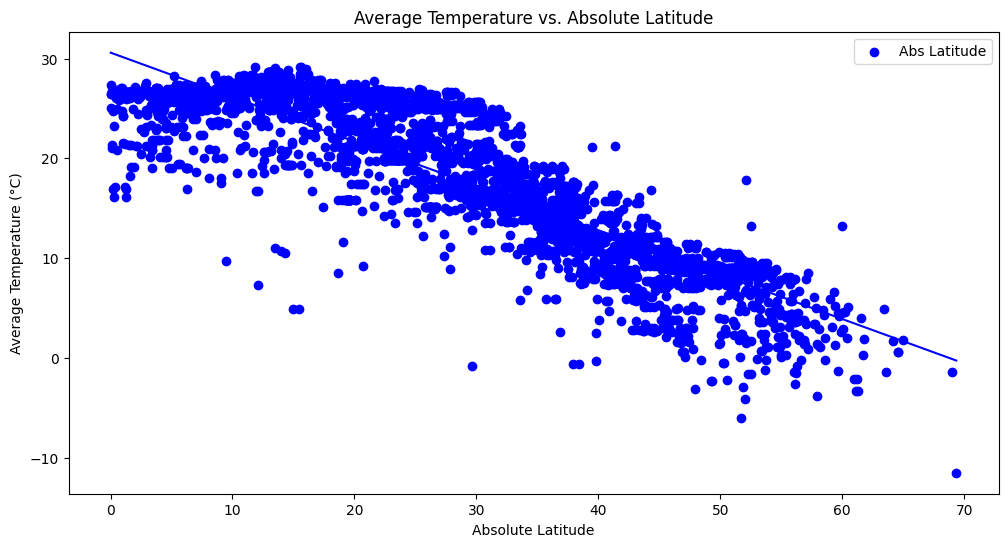

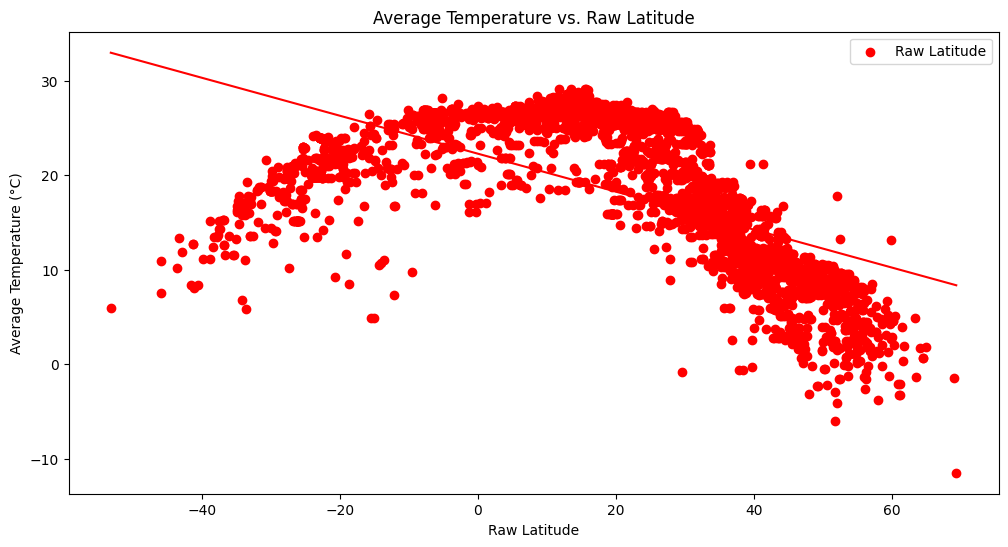

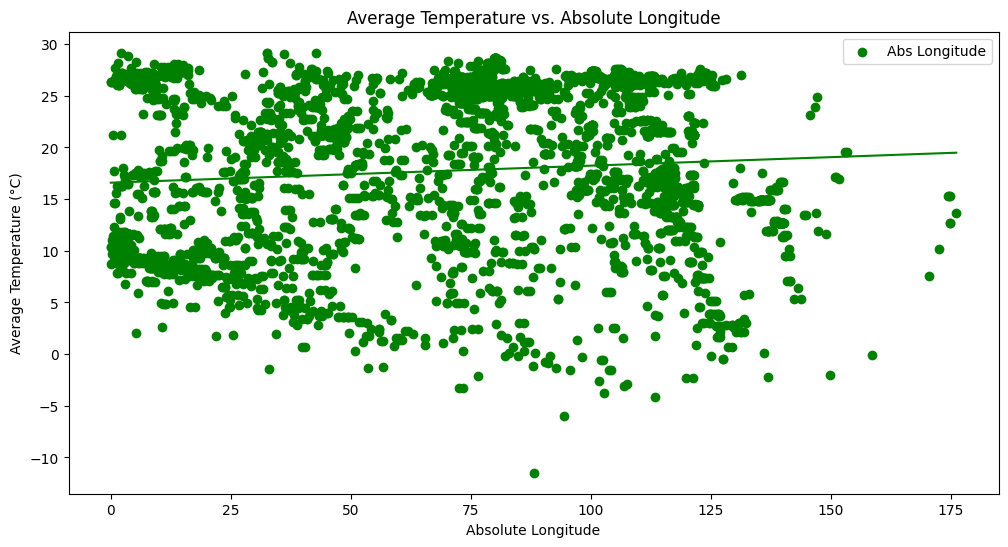

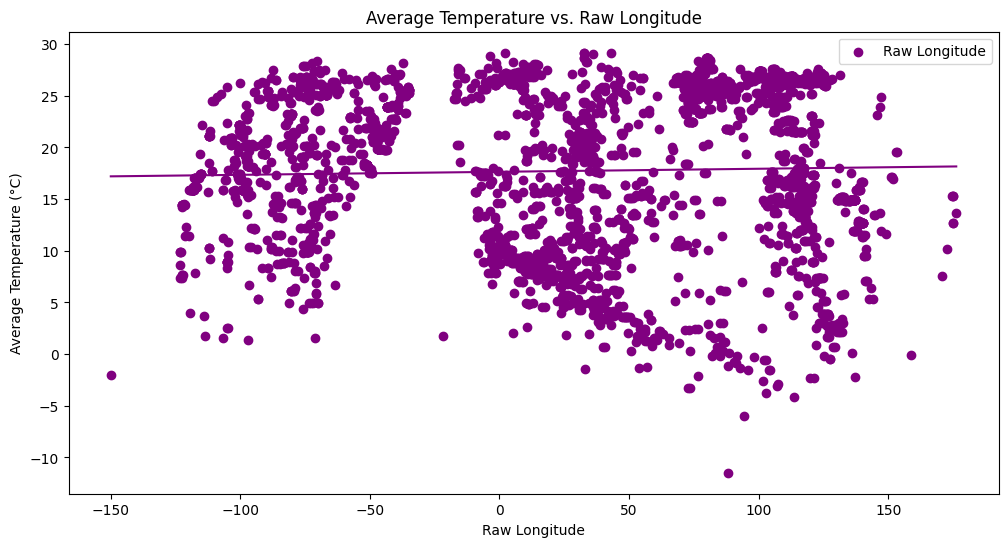

In [16]:
# Visualization for AbsLatitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], color='blue', label='Abs Latitude')
m, b = np.polyfit(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_latitude['AbsLatitude'], m*average_temp_by_latitude['AbsLatitude'] + b, color='blue')
plt.title('Average Temperature vs. Absolute Latitude')
plt.xlabel('Absolute Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Latitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], color='red', label='Raw Latitude')
m, b = np.polyfit(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_latitude['NumericLatitude'], m*average_temp_by_raw_latitude['NumericLatitude'] + b, color='red')
plt.title('Average Temperature vs. Raw Latitude')
plt.xlabel('Raw Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for AbsLongitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], color='green', label='Abs Longitude')
m, b = np.polyfit(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_longitude['AbsLongitude'], m*average_temp_by_longitude['AbsLongitude'] + b, color='green')
plt.title('Average Temperature vs. Absolute Longitude')
plt.xlabel('Absolute Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Longitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], color='purple', label='Raw Longitude')
m, b = np.polyfit(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_longitude['NumericLongitude'], m*average_temp_by_raw_longitude['NumericLongitude'] + b, color='purple')
plt.title('Average Temperature vs. Raw Longitude')
plt.xlabel('Raw Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

In [17]:
print(f'Correlation between Absolute Latitude and Average Temperature: {correlation_abs_lat}')
print(f'Correlation between Absolute Longitude and Average Temperature: {correlation_abs_long}')
print(f'Correlation between Raw Latitude and Average Temperature: {correlation_raw_lat}')
print(f'Correlation between Raw Longitude and Average Temperature: {correlation_raw_long}')

Correlation between Absolute Latitude and Average Temperature: -0.8737956012808455
Correlation between Absolute Longitude and Average Temperature: 0.08957754366266109
Correlation between Raw Latitude and Average Temperature: -0.6127730193847233
Correlation between Raw Longitude and Average Temperature: 0.02848005281938145


For all but Absolute Latitude and Average Temperature, the lines are poor fits for the data. This makes sense since Latitude is a direct predictor of climate due to the angle at which solar radiation is received, while Longitude has no such effects.

The high correlation with Absolute Longitude and Average Temperature would seem viable had we not included the visualization, but clearly the data distribution is not linear. The large number of outliers greatly affects the slope of the regression line. This doesn't meant here is no relationship, however. There may be another relationship here that we can tease out.

As expected, there is a strong negative correlation between absolute latitude an negative temperature (r^2 ~= -0.87), and a nearly even correlation when raw latitude is used (expected r^2 ~= -0.50, actual ~= -0.61).

Perfect correlations are not to be expected, since many more factors affect local climates than distance from the equator, such as weather patterns and topography.

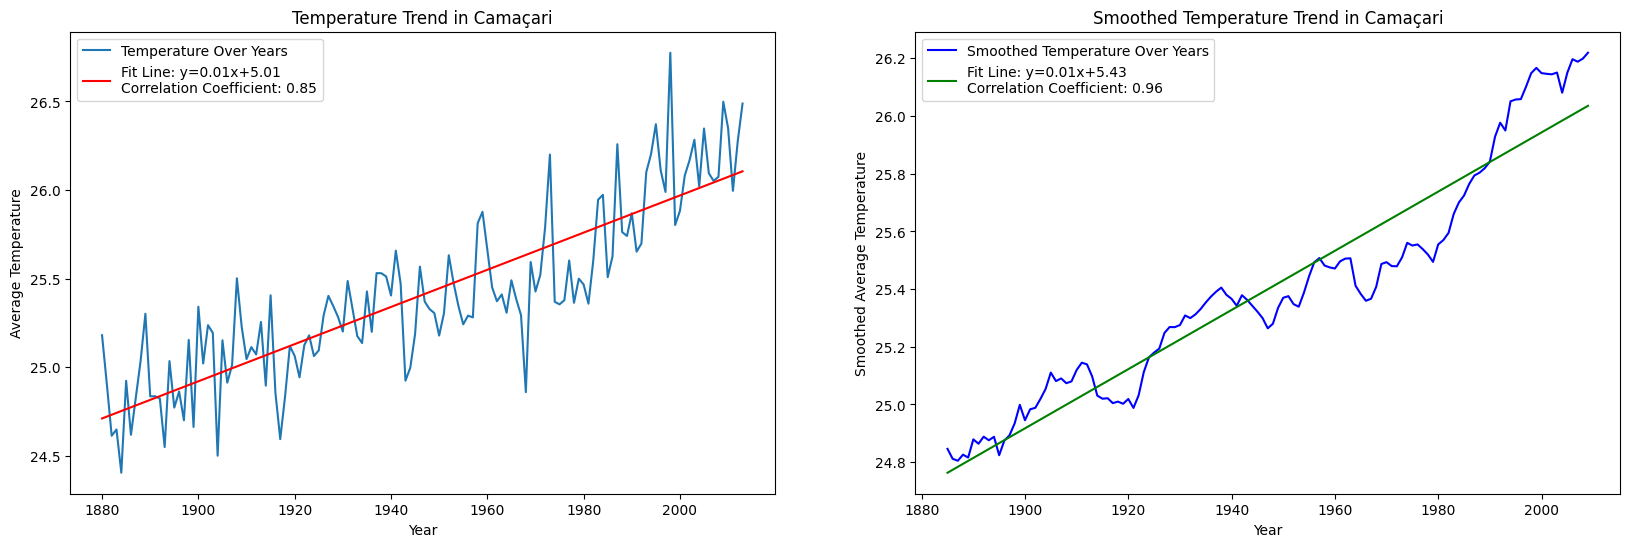

In [28]:
selected_city = random.choice(unique_cities)

city_data = df_updated[df_updated['City'] == selected_city].sort_values('Year')

x = city_data['Year']
y = city_data['AverageTemperature']

# Smoothed data using rolling mean with a window of 10 years
smoothed_y = y.rolling(window=10, center=True).mean()

# lines of best fit
slope, intercept, r_value, _, _ = linregress(x, y)
fit_line = slope * x + intercept

slope_smooth, intercept_smooth, r_value_smooth, _, _ = linregress(x[~smoothed_y.isna()], smoothed_y.dropna())
fit_line_smooth = slope_smooth * x[~smoothed_y.isna()] + intercept_smooth

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Original data graph
axs[0].plot(x, y, label='Temperature Over Years', linestyle='-')
axs[0].plot(x, fit_line, 'r', label=f'Fit Line: y={slope:.2f}x+{intercept:.2f}\nCorrelation Coefficient: {r_value:.2f}')
axs[0].set_title(f'Temperature Trend in {selected_city}')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Average Temperature')
axs[0].legend()

# Smoothed data graph
axs[1].plot(x, smoothed_y, label='Smoothed Temperature Over Years', linestyle='-', color='blue')
axs[1].plot(x[~smoothed_y.isna()], fit_line_smooth, 'g', label=f'Fit Line: y={slope_smooth:.2f}x+{intercept_smooth:.2f}\nCorrelation Coefficient: {r_value_smooth:.2f}')
axs[1].set_title(f'Smoothed Temperature Trend in {selected_city}')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Smoothed Average Temperature')
axs[1].legend()

plt.show()


### Enhancing the Dataset

Adding a continent column to our dataset could potentially be useful to find macro-scale trends.

In [21]:
# looking for locations of ambiguous city names where no Continent is added below
unknown_rows = df_updated[df_updated['City'] == "Zenica"]

# Print the Latitude and Longitude for those rows
print("Latitude and Longitude for Zenica:")
print(unknown_rows[['Latitude', 'Longitude']])

Latitude and Longitude for Zenica:
          Latitude    Longitude
455984  44.199828N  17.9093012E
455985  44.199828N  17.9093012E
455986  44.199828N  17.9093012E
455987  44.199828N  17.9093012E
455988  44.199828N  17.9093012E
...            ...          ...
456113  44.199828N  17.9093012E
456114  44.199828N  17.9093012E
456115  44.199828N  17.9093012E
456116  44.199828N  17.9093012E
456117  44.199828N  17.9093012E

[134 rows x 2 columns]


In [20]:
# get continent name from country name
def country_to_continent(country_name):
    # Special cases (different country names than pycountry_convert uses)
    special_cases = {
        # countries
        'Cote D\'Ivoire': 'Africa',
        'Congo (Democratic Republic Of The)': 'Africa',
        'Burma': 'Asia', 
    }
    
    if country_name in special_cases:
        return special_cases[country_name]
    
    try:
        # Get country code and continent code
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format='default')
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None
    
def city_to_continent(row):
    # Define a mapping for cities to continents for those that weren't marked
    city_to_continent = {
        # cities
        'Abengourou': 'Africa',
        'Abidjan': 'Africa',
        'Agboville': 'Africa',
        'Anyama': 'Africa',
        'Banja Luka': 'Europe',
        'Bissau': 'Africa',
        'Bouaké': 'Africa',
        'Daloa': 'Africa',
        'Divo': 'Africa',
        'Gagnoa': 'Africa',
        'Korhogo': 'Africa',
        'Man': 'Africa',
        'Mostar': 'Europe',
        'Saint Denis': 'Africa', # geographically closer to Africa than Asia, owned by France...
        'San Pédro': 'Africa', # latitude/longitude place this in Cote D'Ivoire
        'Sarajevo': 'Europe',
        'Soubré': 'Africa',
        'Tuzla': 'Europe',
        'Yamoussoukro': 'Africa',
        'Zenica': 'Europe',
    }
    
    # Check if the Continent is None and the city is in our mapping
    if pd.isnull(row['Continent']) and row['City'] in city_to_continent:
        return city_to_continent[row['City']]
    else:
        return row['Continent']

df_updated['Continent'] = df_updated['Country'].apply(country_to_continent)
df_updated['Continent'] = df_updated.apply(city_to_continent, axis=1)

print(df_updated)

# Verify that all countries were assigned a continent
print('---------------------------')
print('Cities with missing continents:')
# Filter the rows where 'Continent' is None and show the unique cities
missing_continent_cities = df_updated[df_updated['Continent'].isnull()]['City'].unique()
for city in missing_continent_cities:
    print(city)

c:\Users\jacob\Dropbox\2024 Spring\CS 457 DataMining\Temperature Patterns\.venv\lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\jacob\Dropbox\2024 Spring\CS 457 DataMining\Temperature Patterns\.venv\lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


            City  Year  AverageTemperature Country     Latitude   Longitude  \
0       A Coruña  1880           12.837750   Spain  43.3709703N  8.3959425W   
1       A Coruña  1881           13.405000   Spain  43.3709703N  8.3959425W   
2       A Coruña  1882           12.776250   Spain  43.3709703N  8.3959425W   
3       A Coruña  1883           12.260833   Spain  43.3709703N  8.3959425W   
4       A Coruña  1884           12.693250   Spain  43.3709703N  8.3959425W   
...          ...   ...                 ...     ...          ...         ...   
461607    Ürümqi  2009            7.287417   China   43.419754N  87.319461E   
461608    Ürümqi  2010            6.650083   China   43.419754N  87.319461E   
461609    Ürümqi  2011            6.806083   China   43.419754N  87.319461E   
461610    Ürümqi  2012            6.600167   China   43.419754N  87.319461E   
461611    Ürümqi  2013            9.472000   China   43.419754N  87.319461E   

        NumericLatitude  NumericLongitude  AbsLatit

### Enhancing the Dataset

The Köppen climate classification divides every region of the world into five main groups, each represented by a letter, and thirty subgroups with additional letters. We may be able to find tighter correlations between temperature trends if we also take into account the climate classification of each city in this dataset.

I will add a column with the Köppen climate classification for each city with data near the present day (1991-2020). Note it is expected these classifications will change over time as global average temperature increases. Data was obtained via the maps referenced in [this paper](https://www.nature.com/articles/sdata2018214).

Be warned, the cell below may take ~20 minutes to run.

In [22]:
unique_locations = df_updated[['City', 'NumericLatitude', 'NumericLongitude']].drop_duplicates()

# Use to add kcc to df
def get_kcc_for_location(row):
    return lookupCZ(row['NumericLatitude'], row['NumericLongitude'])

unique_locations['kcc'] = unique_locations.apply(get_kcc_for_location, axis=1)
kcc_mapping = unique_locations.set_index('City')['kcc'].to_dict()

# Apply the mapping to the main DataFrame to fill in KCC for all rows quickly
df_updated['kcc'] = df_updated['City'].map(kcc_mapping)

cities_without_kcc = df_updated[df_updated['kcc'].isnull()]['City'].unique()

In [23]:
# Make sure all cities had kcc added in
print("Cities with no KCC applied:")
for city in cities_without_kcc:
    print(city)

Cities with no KCC applied:


In [24]:
# Verify Continents and kccs added as expected
print(df_updated)

df_updated.describe()

            City  Year  AverageTemperature Country     Latitude   Longitude  \
0       A Coruña  1880           12.837750   Spain  43.3709703N  8.3959425W   
1       A Coruña  1881           13.405000   Spain  43.3709703N  8.3959425W   
2       A Coruña  1882           12.776250   Spain  43.3709703N  8.3959425W   
3       A Coruña  1883           12.260833   Spain  43.3709703N  8.3959425W   
4       A Coruña  1884           12.693250   Spain  43.3709703N  8.3959425W   
...          ...   ...                 ...     ...          ...         ...   
461607    Ürümqi  2009            7.287417   China   43.419754N  87.319461E   
461608    Ürümqi  2010            6.650083   China   43.419754N  87.319461E   
461609    Ürümqi  2011            6.806083   China   43.419754N  87.319461E   
461610    Ürümqi  2012            6.600167   China   43.419754N  87.319461E   
461611    Ürümqi  2013            9.472000   China   43.419754N  87.319461E   

        NumericLatitude  NumericLongitude  AbsLatit

,Year,AverageTemperature,NumericLatitude,NumericLongitude,AbsLatitude,AbsLongitude
count,461612.000000,461612.000000,461612.000000,461612.000000,461612.000000,461612.000000
mean,1946.555872,17.751024,22.771432,33.197200,28.919743,69.819964
std,38.654517,7.689601,23.323688,74.221289,15.039294,41.665552
min,1880.000000,-14.812000,-53.162569,-149.894852,0.022690,0.009659
25%,1913.000000,11.487646,9.340016,-5.930183,17.831773,33.639080
50%,1947.000000,18.502333,27.583333,36.309581,29.340737,75.210095
75%,1980.000000,25.236854,39.690552,100.925671,39.800550,106.630200
max,2013.000000,31.082625,69.344405,176.167505,69.344405,176.167505


### Finding Patterns in the Data

We want to find patterns within our data.

For instance, what's the correlation between year and average temperature for all of the data? How does it compare to specific countries? Locations? Climate zones? What can we learn?

In [25]:
# Naive approach: looking at everything - data is sparse in the early years
global_correlation = df_updated['Year'].astype(float).corr(df_updated['AverageTemperature'].astype(float))
print(f"Global Correlation between Year and Average Temperature: {global_correlation}")

Global Correlation between Year and Average Temperature: 0.050330377765431325


Global Correlation between Year and Average Temperature: 0.8950598313691919


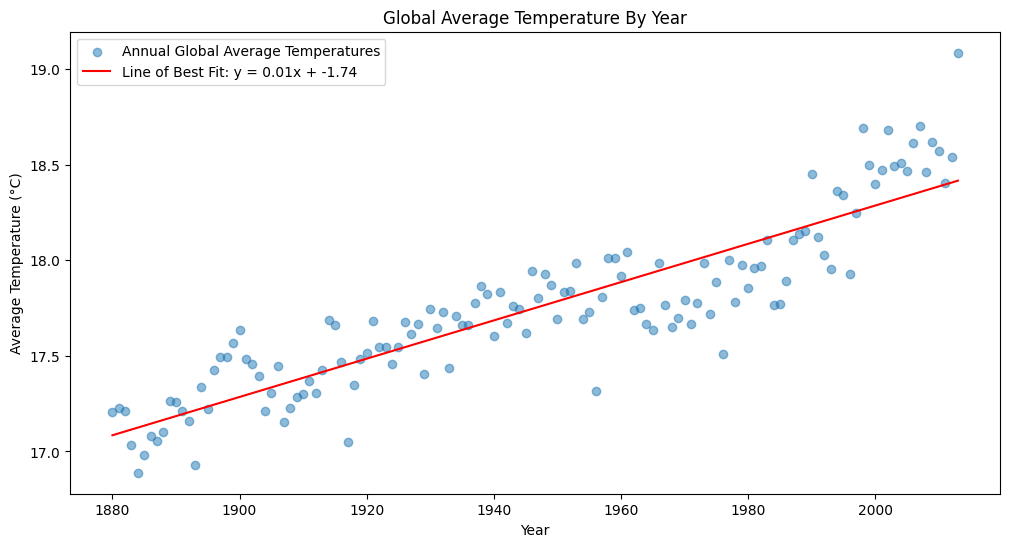

In [26]:
# Better approach: focus on more reliable/relevant data. Aggregate by year, use mean to reduce influence of regional temperature variability
years = df_global_average['Year'].astype(float)
mean_temperatures = df_global_average['GlobalAverageTemperature'].astype(float)
m, b = np.polyfit(years, mean_temperatures, 1)
plt.figure(figsize=(12, 6))
plt.scatter(years, mean_temperatures, alpha=0.5, label='Annual Global Average Temperatures')
plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

global_correlation = years.corr(mean_temperatures)
print(f'Global Correlation between Year and Average Temperature: {global_correlation}')

plt.title('Global Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

Global correlation between year and Average Temperature is pretty high, about 0.896, meaning the variable Year explains about 88% of the variance in Average Temperature.

In [27]:
continent_counts = df_updated['Continent'].value_counts()

for continent, count in continent_counts.items():
    print(f'{continent}: {count}')

print()

kcc_counts = df_updated['kcc'].value_counts()

for kcc, count in kcc_counts.items():
    print(f'{kcc}: {count}')

Asia: 210380
Europe: 87368
North America: 55208
South America: 53460
Africa: 52116
Oceania: 3080

Cfa: 77184
Aw: 75759
Cfb: 48754
Cwa: 35900
BSh: 31997
Am: 25276
Af: 24781
Csa: 24388
Dfb: 23450
BSk: 22646
BWh: 20449
Cwb: 9211
Csb: 8039
Dwa: 7102
As: 6603
Dfa: 5762
BWk: 5488
Dwb: 3618
Dfc: 2546
Dsb: 804
Ocean: 518
Cfc: 399
Dsa: 268
Dwc: 268
ET: 268
Dsc: 134


In [28]:
def plot_data_and_correlation(df, group_column, title_prefix):
    correlations = {}
    
    for group in df[group_column].unique():
        df_group = df[df[group_column] == group]
        yearly_avg_temp = df_group.groupby('Year')['AverageTemperature'].mean().reset_index()
        correlation = yearly_avg_temp['Year'].astype(float).corr(yearly_avg_temp['AverageTemperature'].astype(float))
        correlations[group] = correlation
        years = yearly_avg_temp['Year'].astype(float)
        avg_temps = yearly_avg_temp['AverageTemperature'].astype(float)
        
        # line of best fit
        m, b = np.polyfit(years, avg_temps, 1)
        
        plt.figure(figsize=(12, 6))
        plt.scatter(years, avg_temps, alpha=0.5, label=f'{group} Average Temperatures')
        plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')
        plt.title(f'{title_prefix} By Year for {group}')
        plt.xlabel('Year')
        plt.ylabel('Average Temperature (°C)')
        plt.legend()
        plt.show()
    
    for group, correlation in correlations.items():
        print(f'Correlation between Year and Average Temperature for {group}: {correlation}')
        
    return correlations

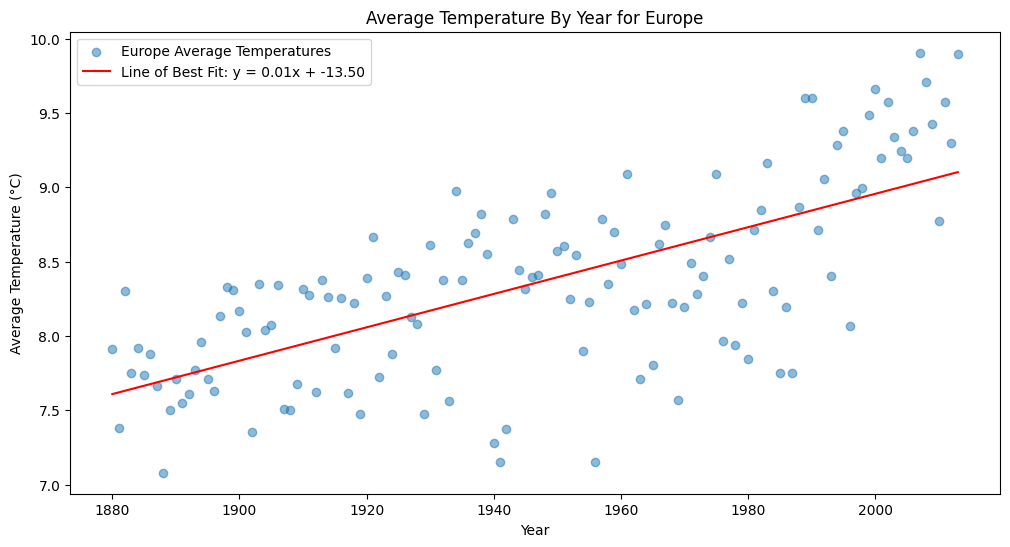

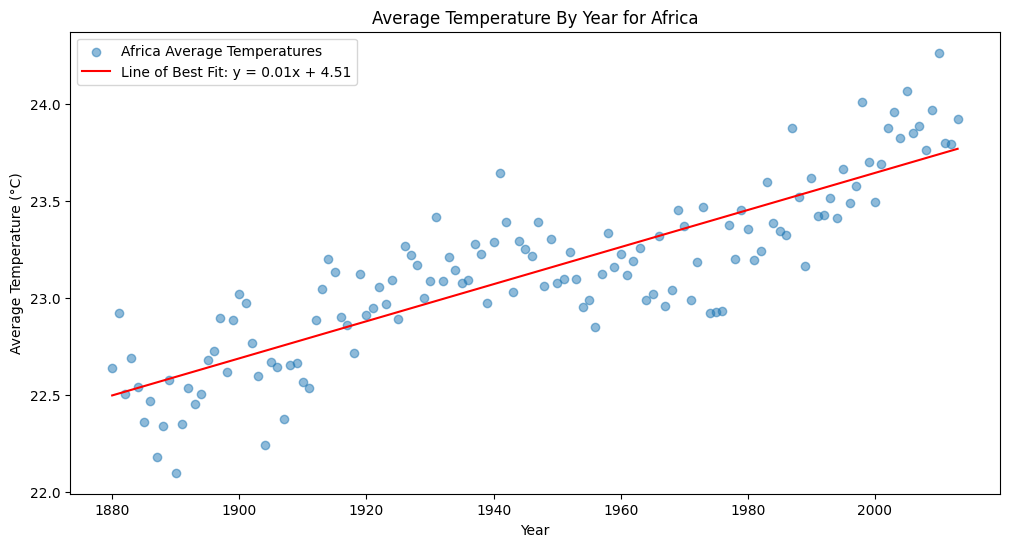

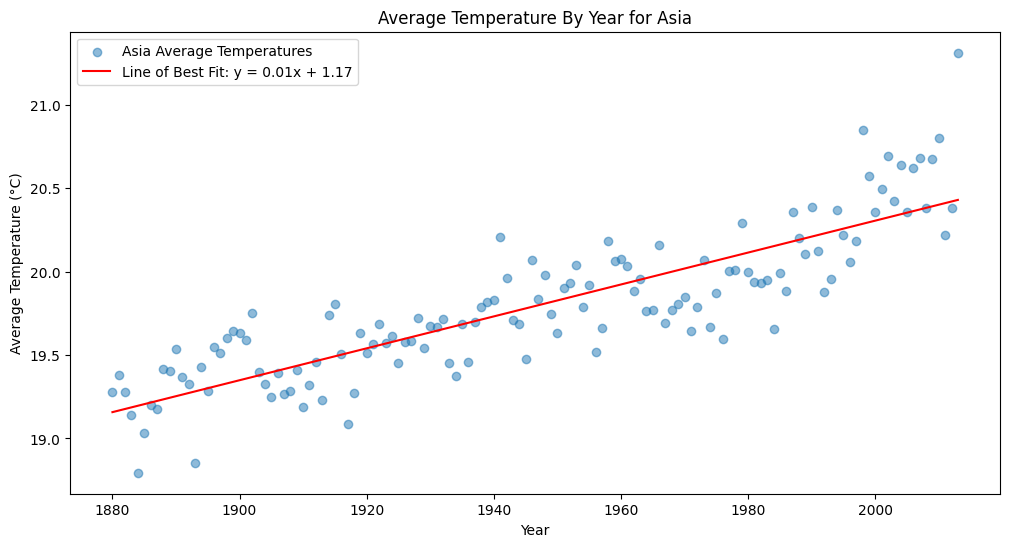

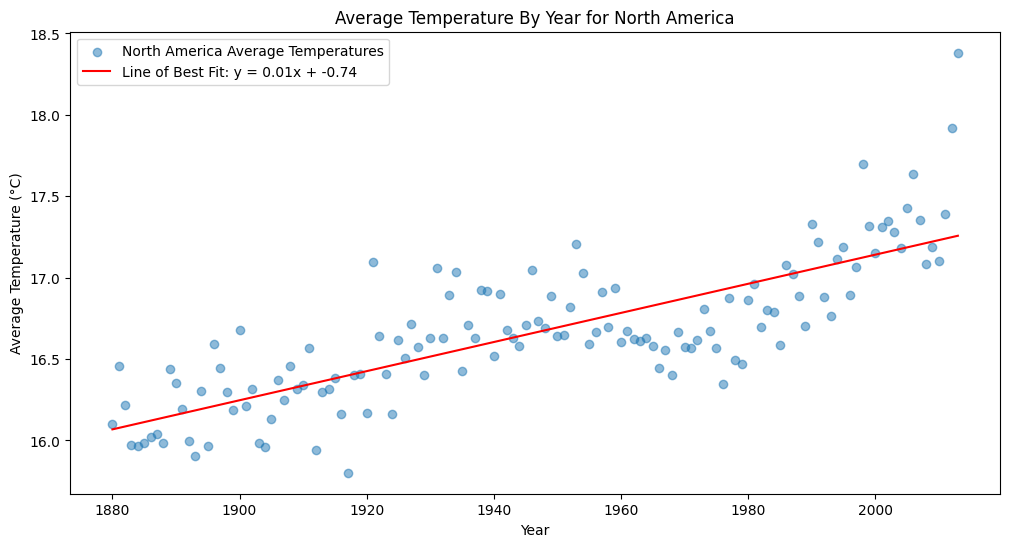

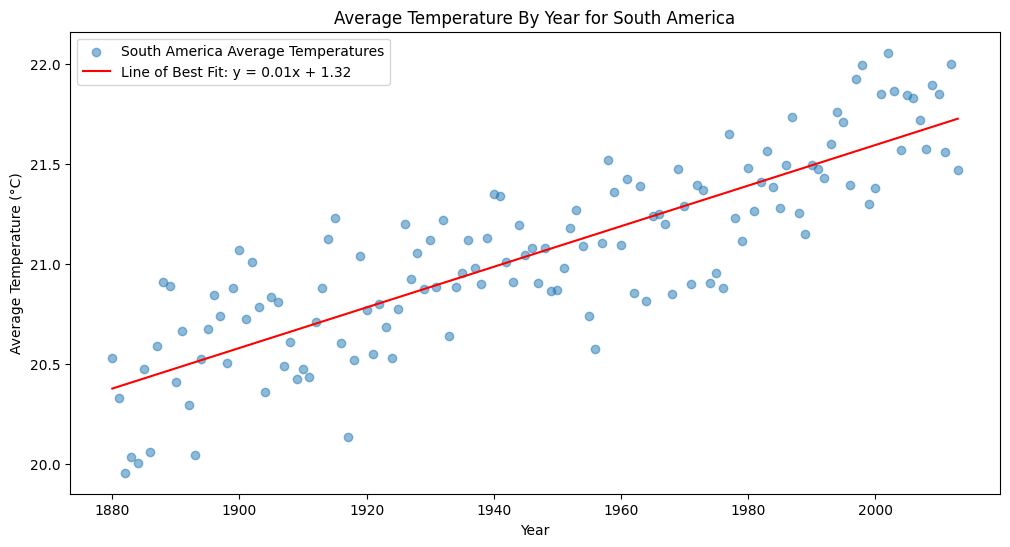

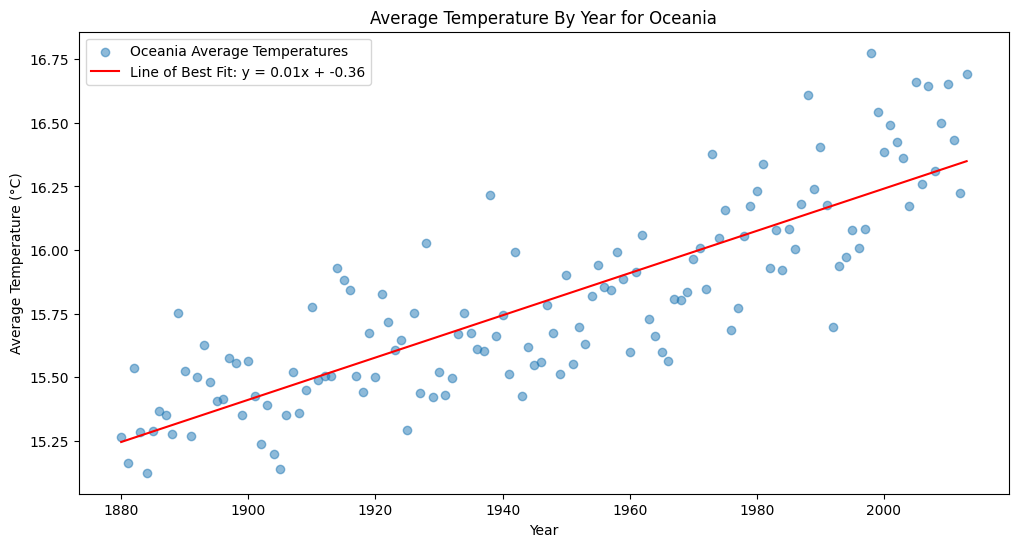

Correlation between Year and Average Temperature for Europe: 0.6803654313940591
Correlation between Year and Average Temperature for Africa: 0.8596727125512974
Correlation between Year and Average Temperature for Asia: 0.8562663641608523
Correlation between Year and Average Temperature for North America: 0.7942020911771275
Correlation between Year and Average Temperature for South America: 0.8474239477548128
Correlation between Year and Average Temperature for Oceania: 0.8423904861369935


In [29]:
# searching for high correlation continents
continent_correlations = plot_data_and_correlation(df_updated, 'Continent', 'Average Temperature')

high_corr_continents = [continent for continent, corr in continent_correlations.items() if corr >= global_correlation]
high_corr_continent_cities = {continent: df_updated[df_updated['Continent'] == continent]['City'].unique().tolist() for continent in high_corr_continents}
for continent in high_corr_continent_cities:
    print(f"Cities in {continent} with high correlation:", high_corr_continent_cities[continent])


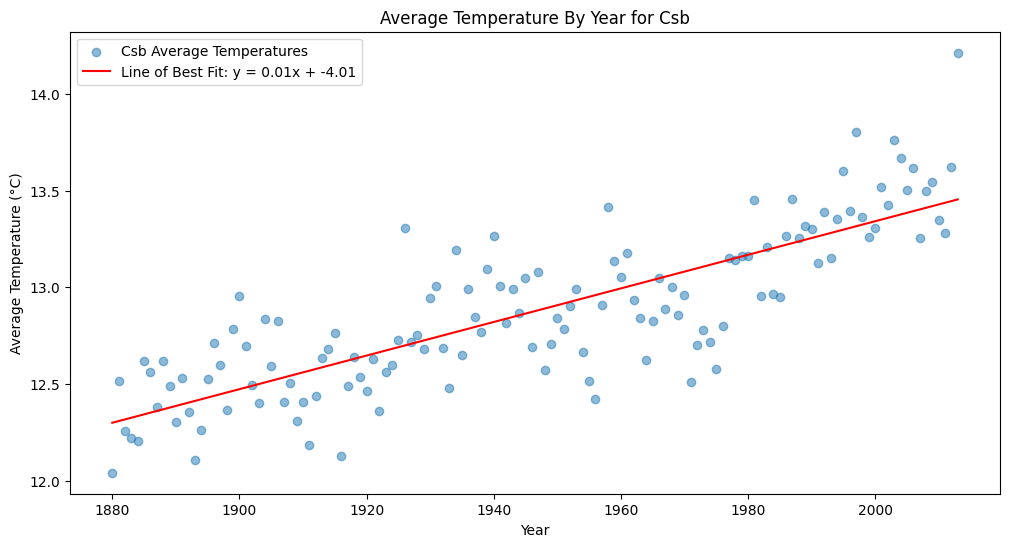

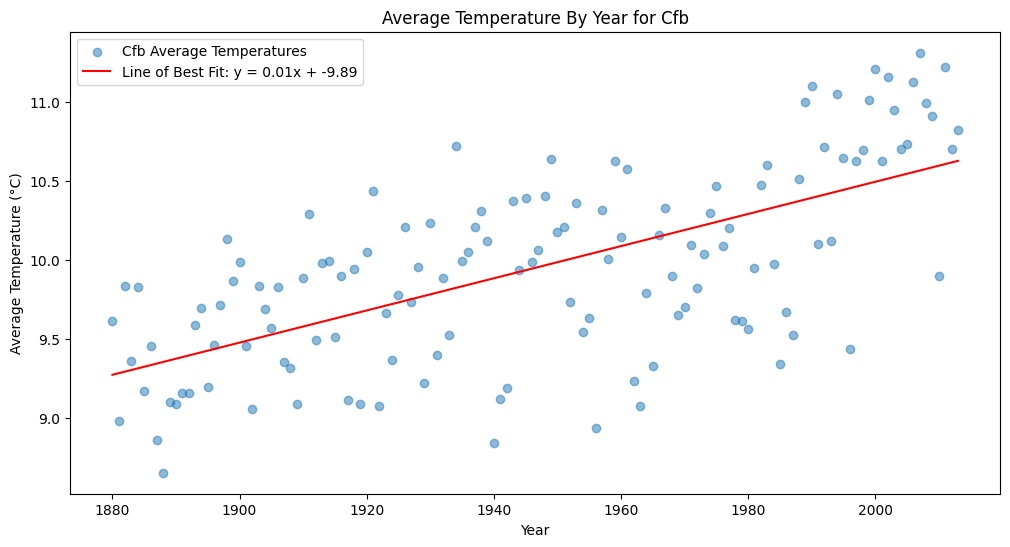

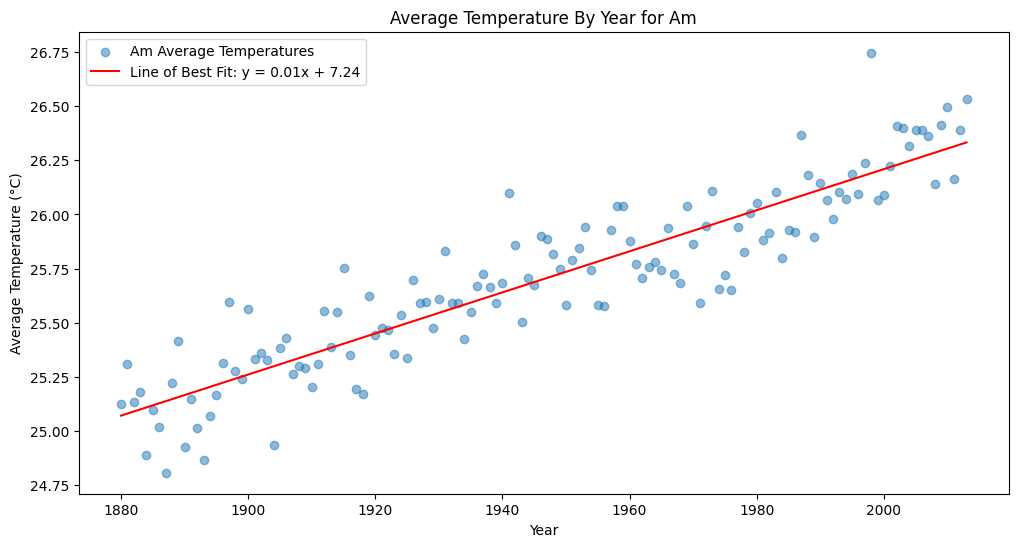

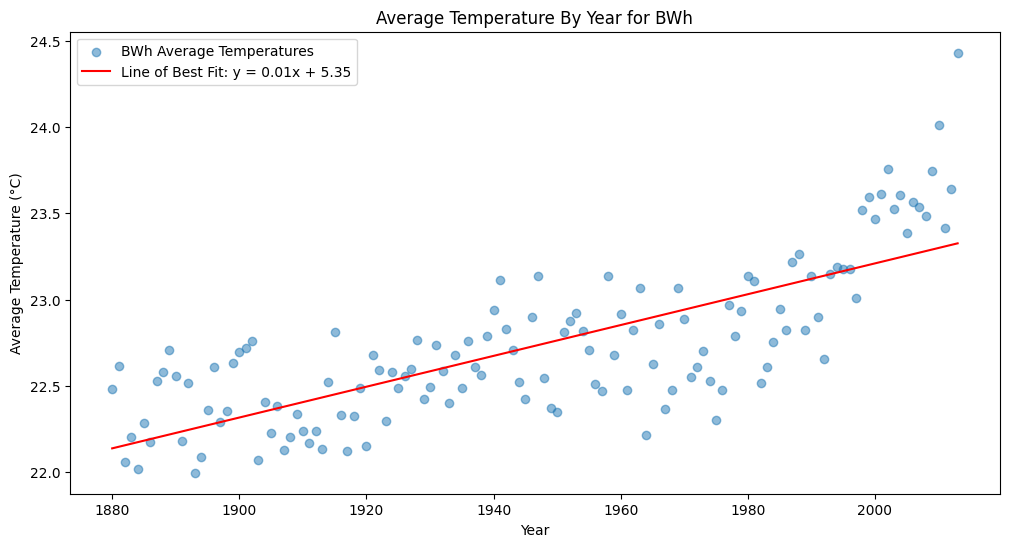

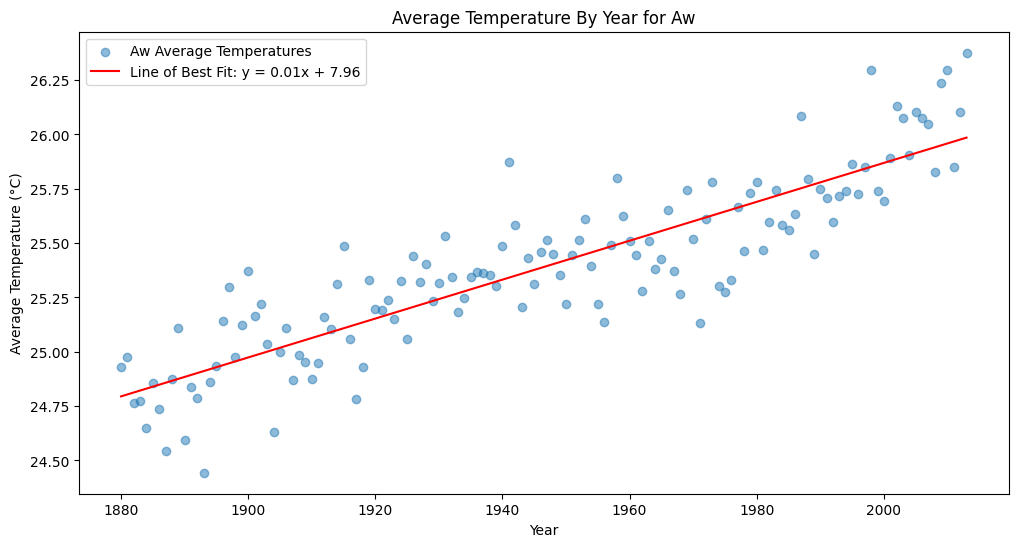

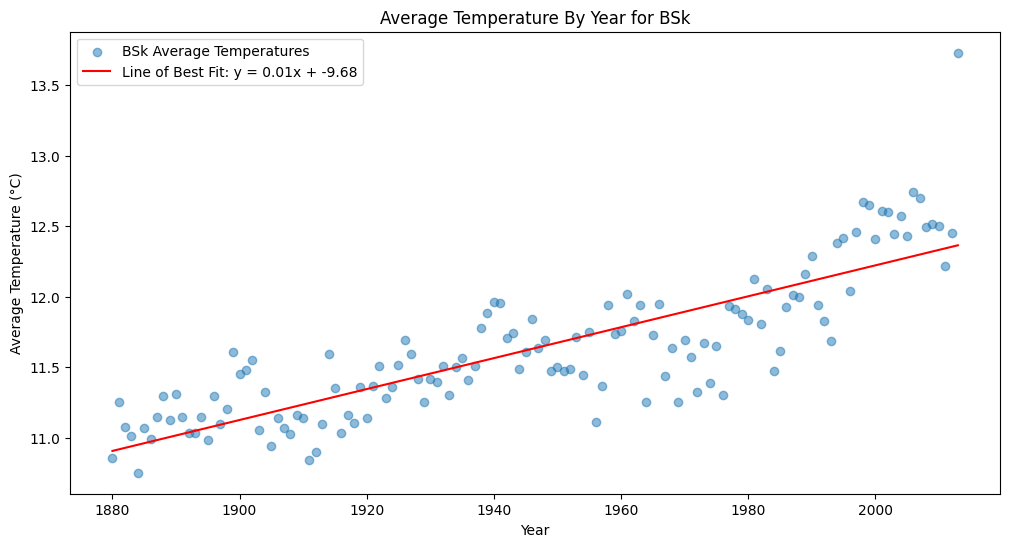

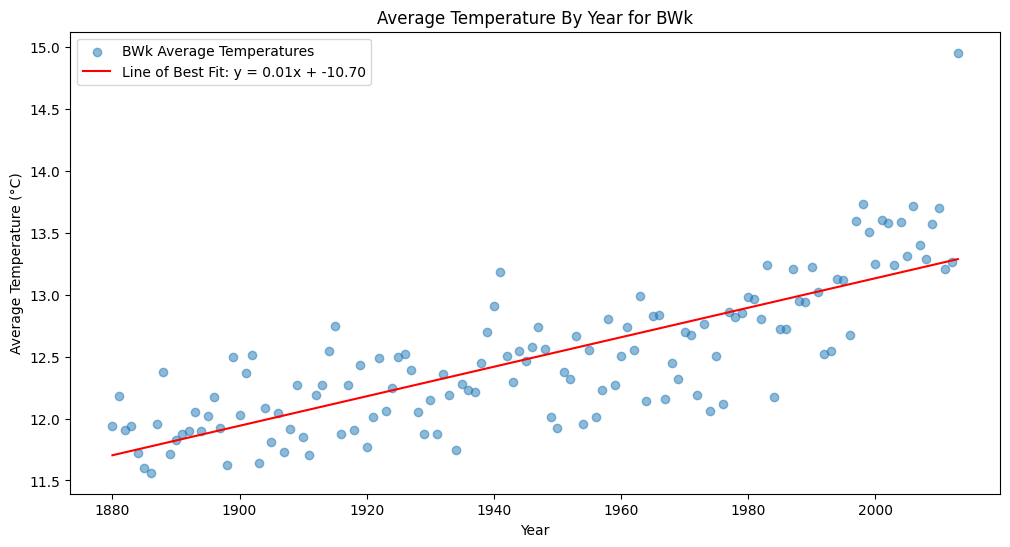

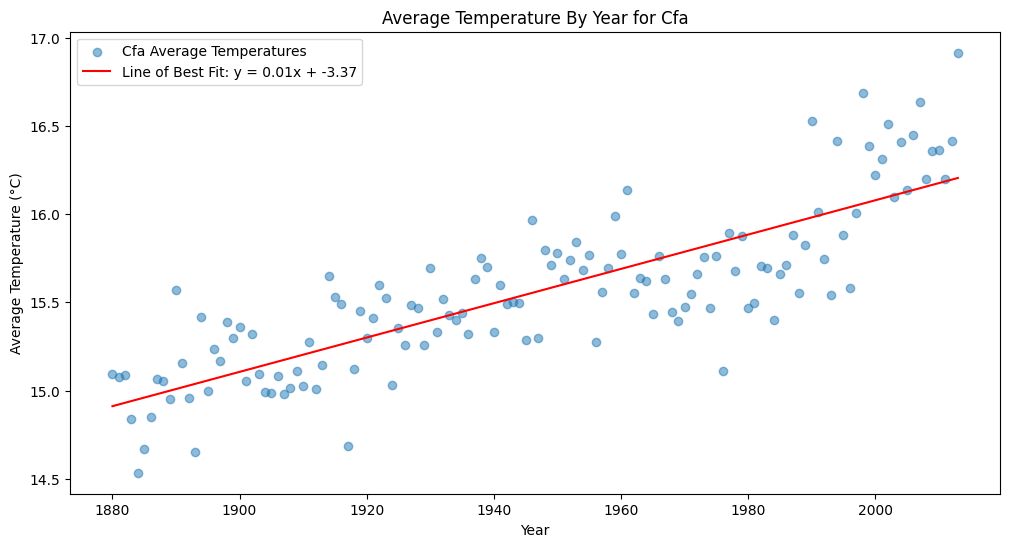

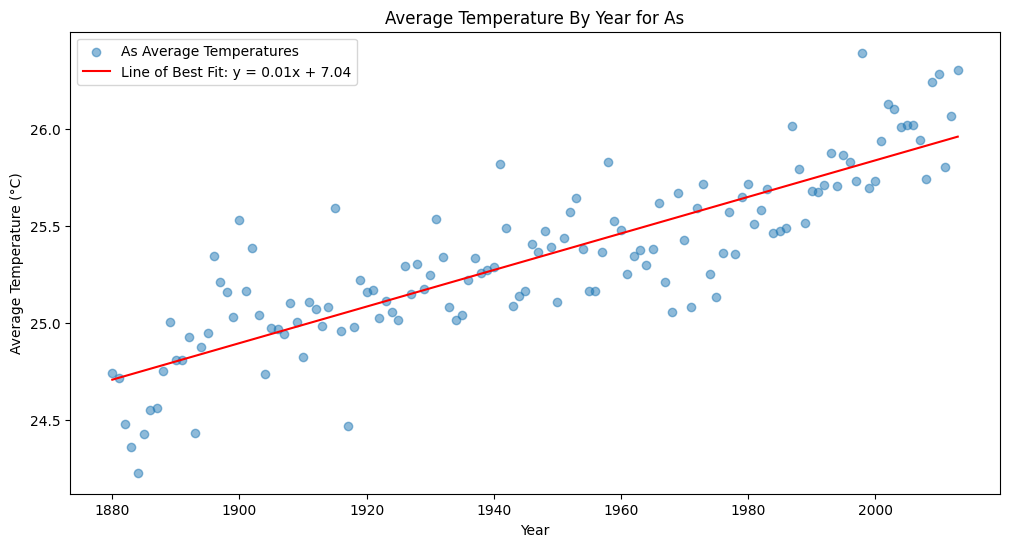

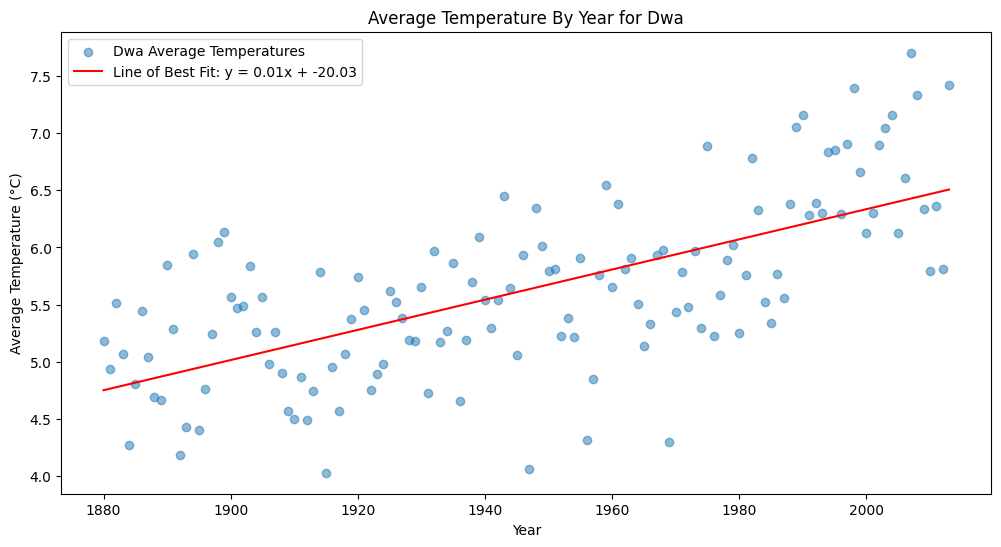

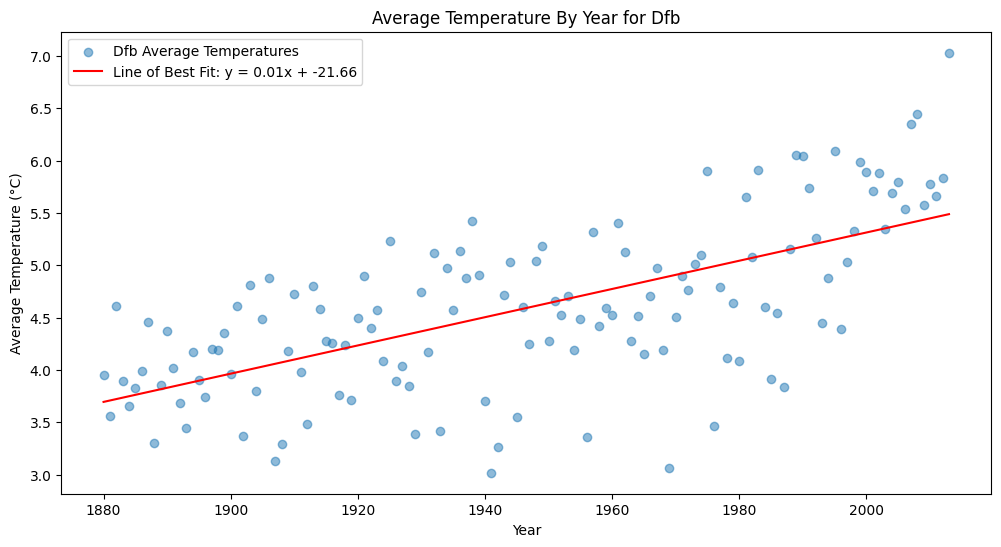

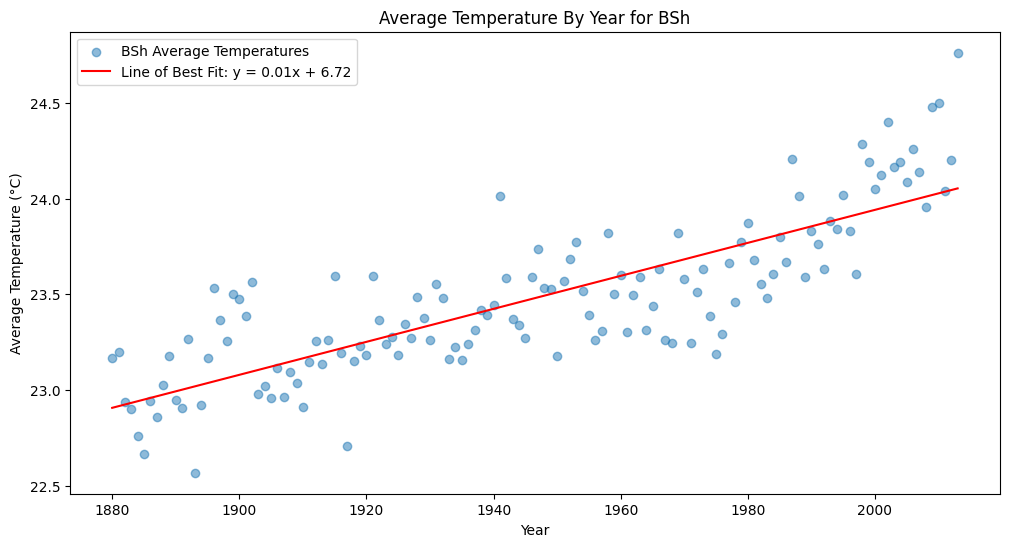

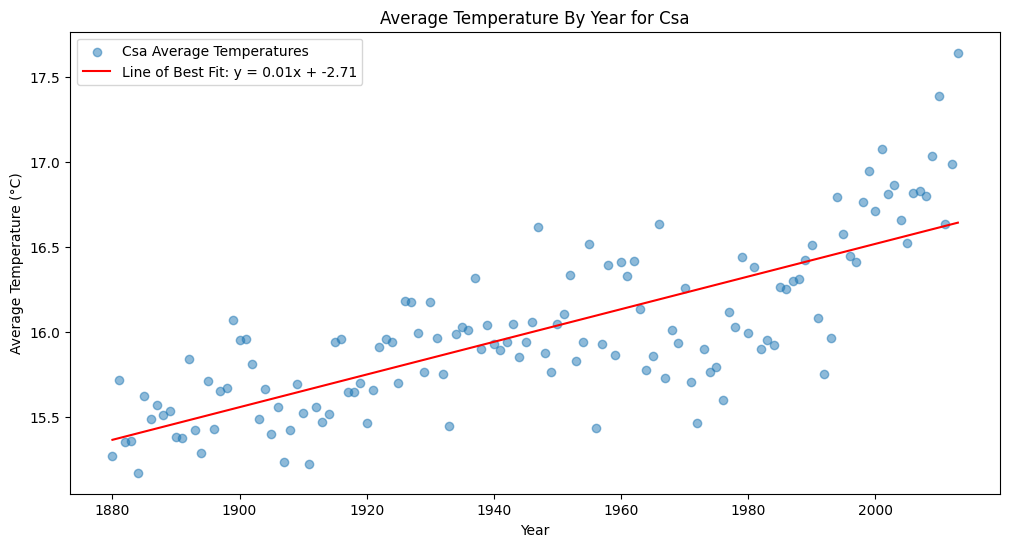

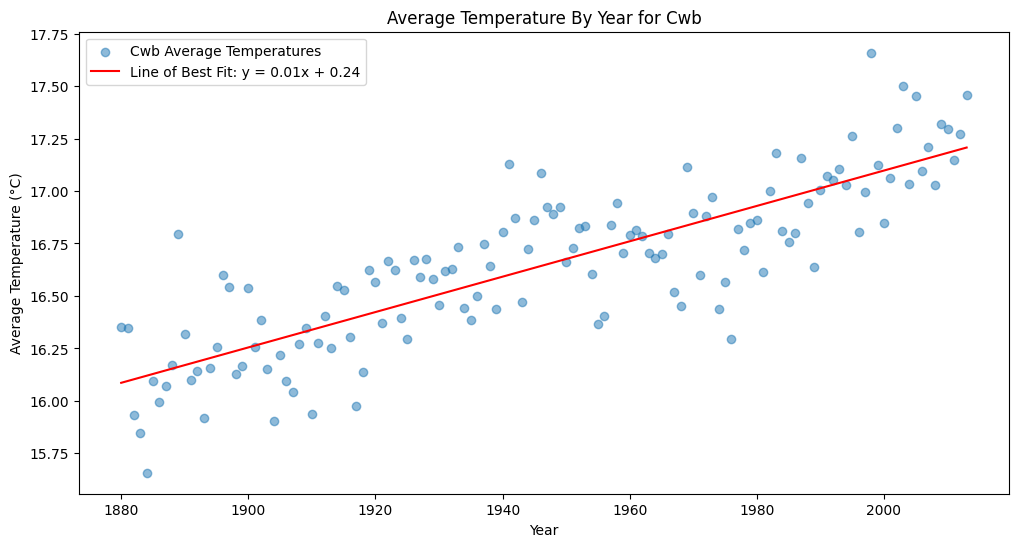

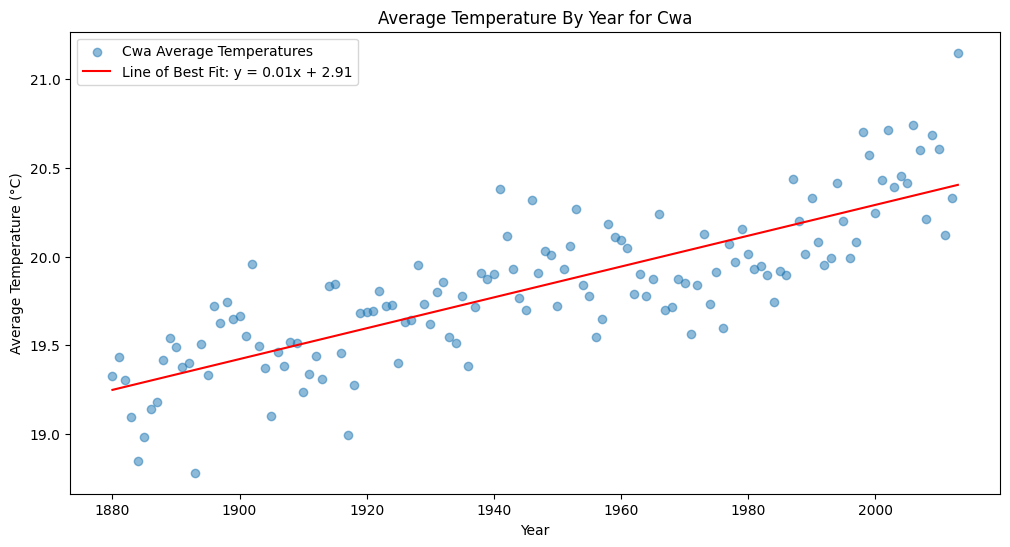

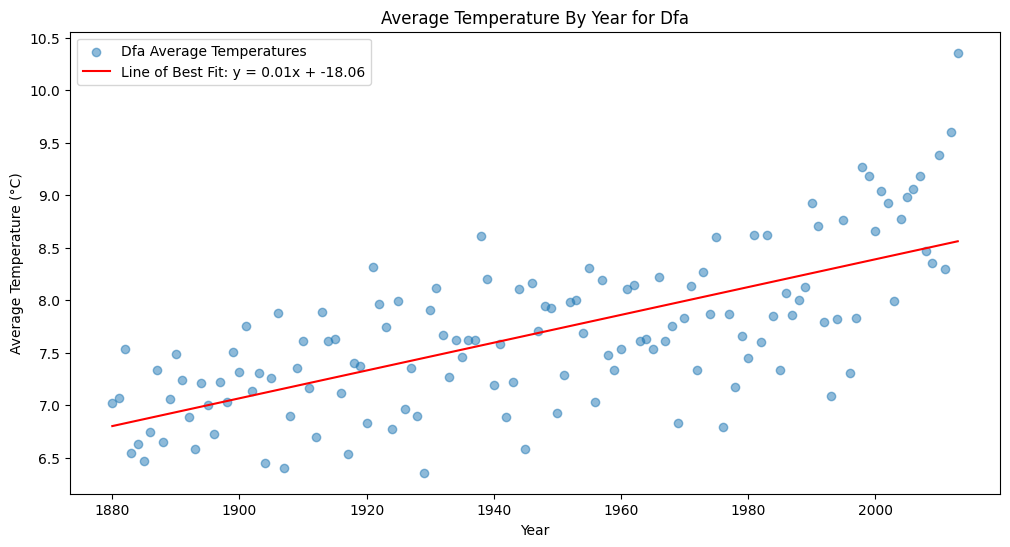

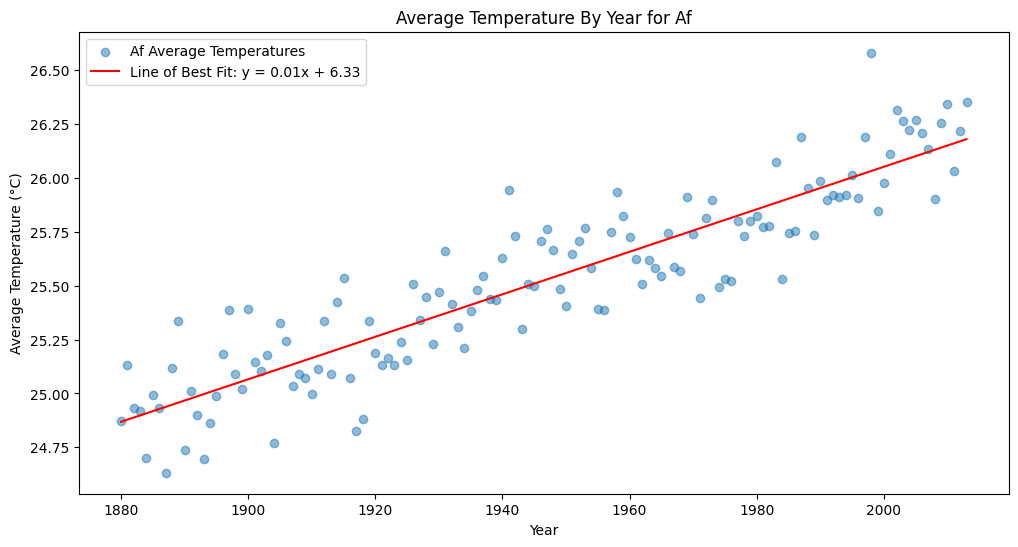

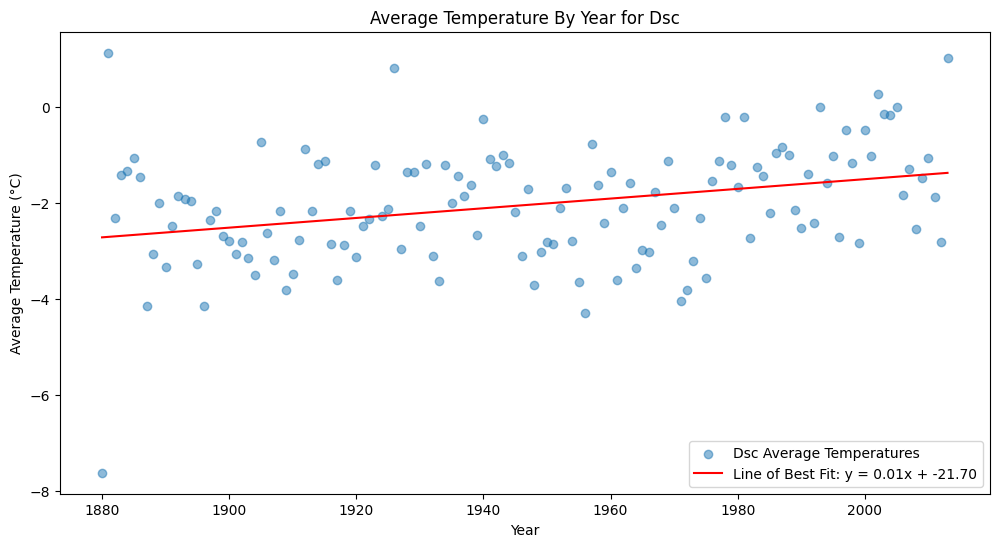

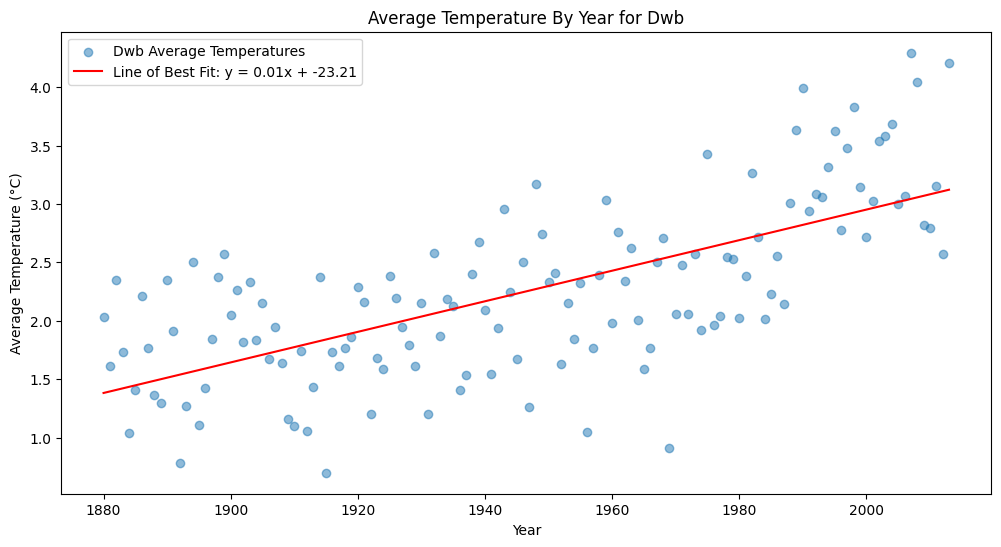

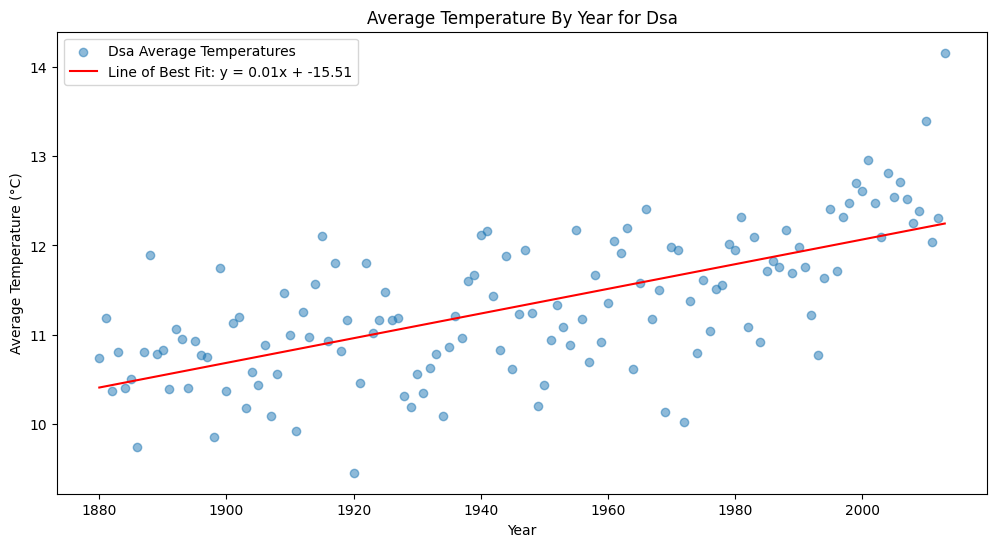

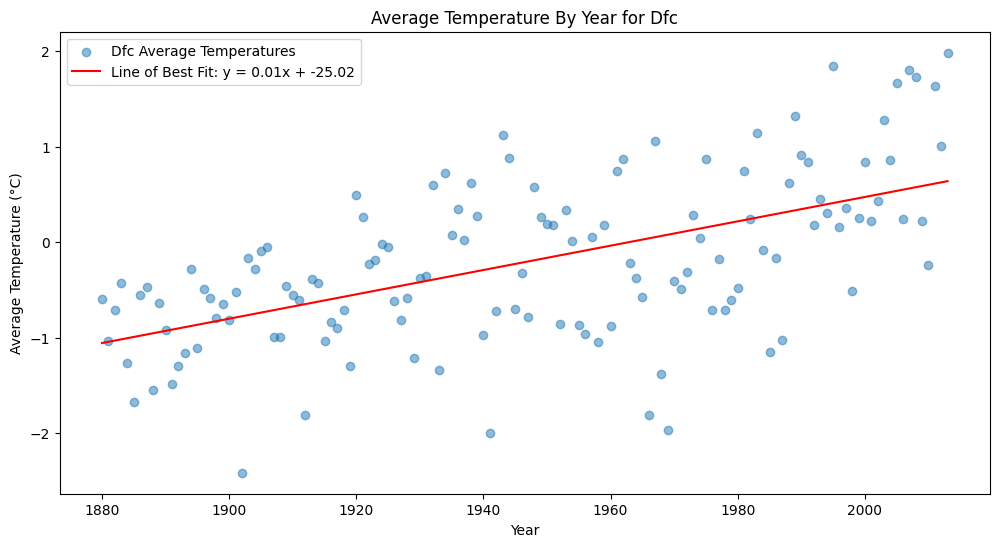

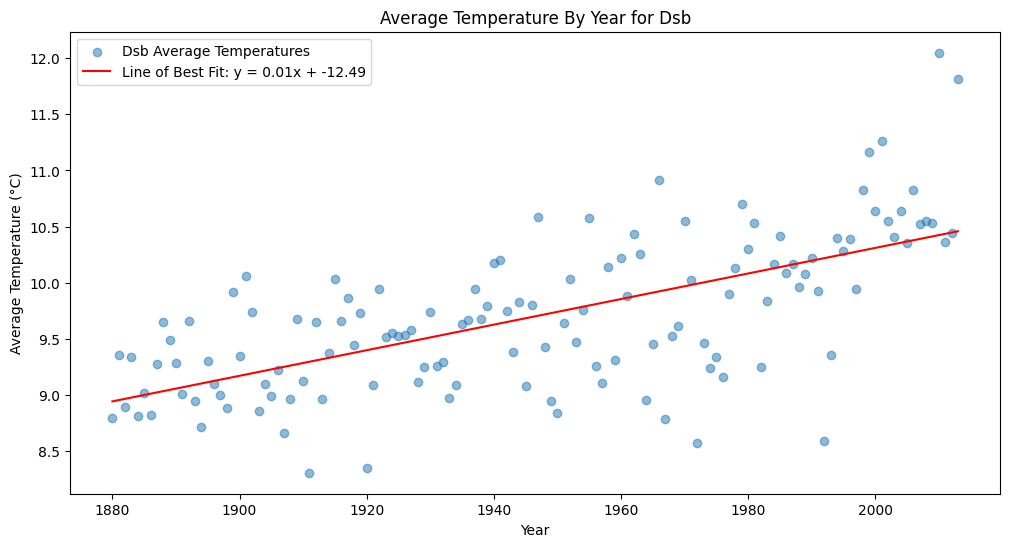

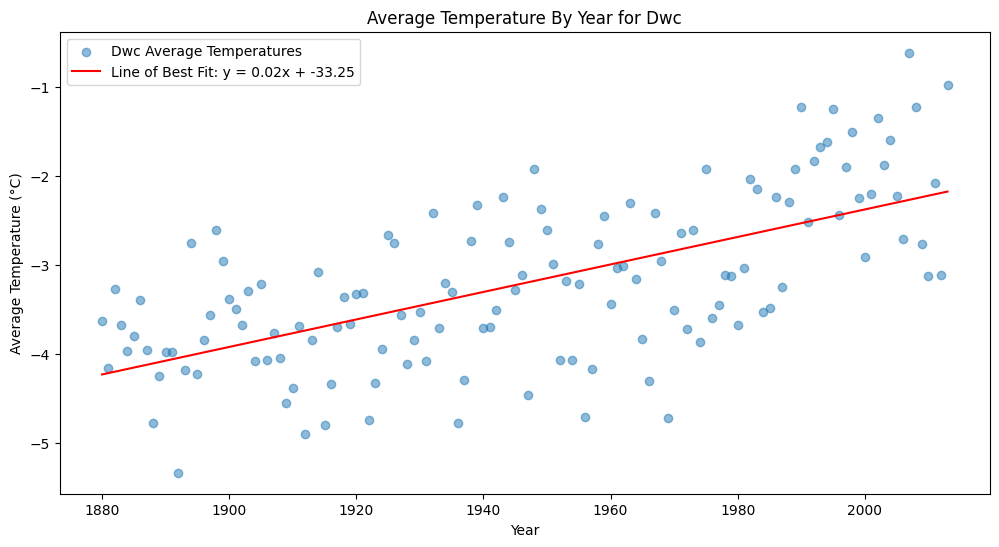

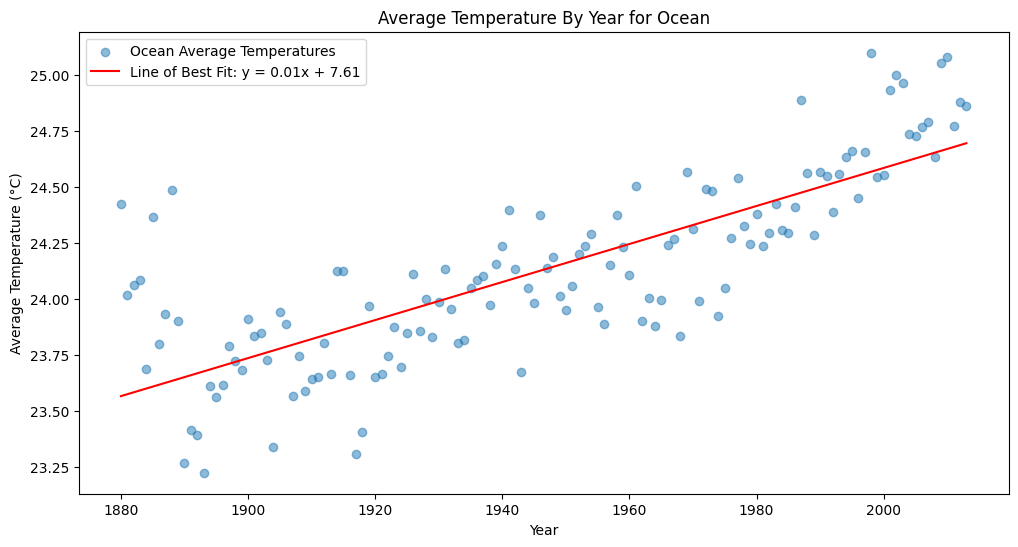

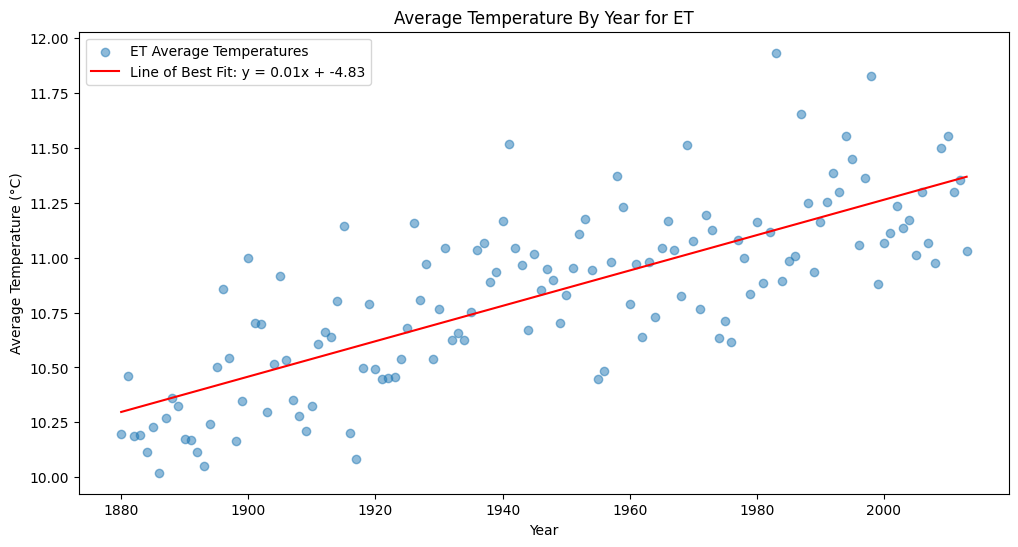

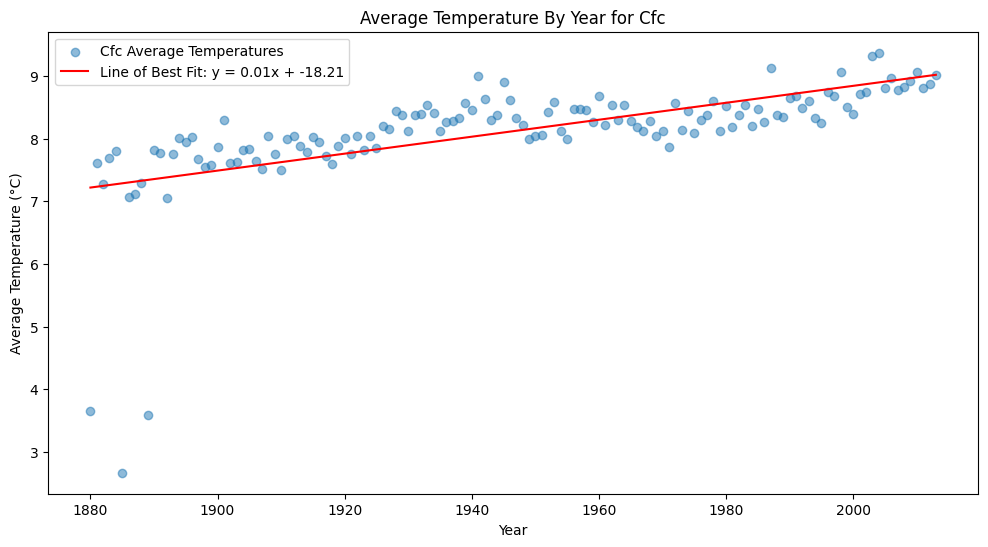

Correlation between Year and Average Temperature for Csb: 0.8199339307170468
Correlation between Year and Average Temperature for Cfb: 0.6511702636174608
Correlation between Year and Average Temperature for Am: 0.9120357226964858
Correlation between Year and Average Temperature for BWh: 0.7662466283943333
Correlation between Year and Average Temperature for Aw: 0.8762836432112805
Correlation between Year and Average Temperature for BSk: 0.8357365524325885
Correlation between Year and Average Temperature for BWk: 0.7964365996641098
Correlation between Year and Average Temperature for Cfa: 0.8271086580812979
Correlation between Year and Average Temperature for As: 0.8534604598729159
Correlation between Year and Average Temperature for Dwa: 0.6667310864829119
Correlation between Year and Average Temperature for Dfb: 0.6497164097800248
Correlation between Year and Average Temperature for BSh: 0.8181976743864311
Correlation between Year and Average Temperature for Csa: 0.7790360313857362
Co

In [30]:
# searching for high correlation climate types
kcc_correlations = plot_data_and_correlation(df_updated, 'kcc', 'Average Temperature')

high_corr_kccs = [kcc for kcc, corr in kcc_correlations.items() if corr >= global_correlation]
high_corr_kcc_cities = {kcc: df_updated[df_updated['kcc'] == kcc]['City'].unique().tolist() for kcc in high_corr_kccs}
for kcc in high_corr_kcc_cities:
    print(f"Cities in {kcc} KCC with high correlation:", high_corr_kcc_cities[kcc])

Let's look at the original data and see how the correlations between cities and countries hold up (the non-augmented data)

In [31]:
def calc_corr(group):
    return group['AverageTemperature'].corr(group['Year'])

grouped = df_updated.groupby('City', as_index=False).apply(lambda group: calc_corr(group), include_groups=False).rename(columns={None: 'Correlation'})

if isinstance(grouped, pd.Series):
    grouped = grouped.reset_index(name='Correlation')

merged_df = pd.merge(df_updated.drop_duplicates('City'), grouped, on='City')

# Filter cities based on global_correlation
filtered_cities = merged_df[merged_df['Correlation'] > global_correlation]

# Print cities with higher than global correlation
for _, row in filtered_cities.iterrows():
    print(f"{row['City']}, {row['Country']}, {row['Continent']}, {row['kcc']}, {row['Correlation']}")

# Calculate the unique counts
unique_cities = filtered_cities['City'].nunique()
unique_countries = filtered_cities['Country'].nunique()
unique_continents = filtered_cities['Continent'].nunique()

# Print out the unique counts
print(f'\nUnique cities: {unique_cities}')
print(f'Unique countries: {unique_countries}')
print(f'Unique continents: {unique_continents}')


Adiwerna, Indonesia, Asia, Am, 0.9020763581444889
Arjawinangun, Indonesia, Asia, Am, 0.9105746293607749
Astanajapura, Indonesia, Asia, Am, 0.9105746293607749
Babakan, Indonesia, Asia, Af, 0.9105746293607749
Bandung, Indonesia, Asia, Af, 0.9105746293607749
Banjaran, Indonesia, Asia, Af, 0.9105746293607749
Baturaja, Indonesia, Asia, Af, 0.8957490585378484
Bekasi, Indonesia, Asia, Af, 0.9039582515748951
Bengkulu, Indonesia, Asia, Af, 0.8951236836734664
Bogor, Indonesia, Asia, Af, 0.9109853563965258
Brebes, Indonesia, Asia, Am, 0.9020763581444889
Butuan, Philippines, Asia, Af, 0.8990484616936386
Ciamis, Indonesia, Asia, Am, 0.9105746293607749
Ciampea, Indonesia, Asia, Af, 0.9109853563965258
Cianjur, Indonesia, Asia, Af, 0.9105746293607749
Cibadak, Indonesia, Asia, Af, 0.9109853563965258
Cibinong, Indonesia, Asia, Af, 0.9039582515748951
Cibitung, Indonesia, Asia, Af, 0.9039582515748951
Cicalengka, Indonesia, Asia, Am, 0.9105746293607749
Cikampek, Indonesia, Asia, Am, 0.9105746293607749
Cika

In [32]:
# Calculate correlation for each country, print the ones where correlation higher than global
grouped_by_country = df_updated.groupby('Country').apply(lambda group: group['AverageTemperature'].corr(group['Year']), include_groups=False)

filtered_countries = grouped_by_country[grouped_by_country > global_correlation]

for country in filtered_countries.index:
    continent = df_updated[df_updated['Country'] == country]['Continent'].iloc[0]
    print(f"{country}, {continent}, {filtered_countries[country]}")

Climate types where the correlation between Year and Average Temperature is larger than the global correlation suggests that these regions are warming more rapidly than the planet as a whole, based on this dataset. Which regions are these, and what cities are in them?

It should be noted that Climate classifications aren't the end-all, be-all, i.e. there is variability within one climate type and geographic factors as well as human factors can influence temperature, including ocean currents, the urban heat island effect, deforestation, and pollution.

### Further Pattern Examination

Continued in Analysis 2.ipynb

In [33]:
# Put current results into a CSV for later
df_updated.to_csv('Data_augmented.csv', index=False)